In [8]:
import numpy as np
import os 
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns

import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
#import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk
#nltk.download('popular')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eitanb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eitanb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
path = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\DATA"
path_result = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\result"

In [10]:
df=pd.read_csv(path+"/"+"team_results.csv")

In [11]:
df_base=df.drop(columns=['gameID', 'homeTeamID', 'awayTeamID'])


In [25]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12680 entries, 0 to 12679
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   leagueID               12680 non-null  int64  
 1   season                 12680 non-null  int64  
 2   date                   12680 non-null  object 
 3   homeGoals              12680 non-null  int64  
 4   awayGoals              12680 non-null  int64  
 5   homeGoalsHalfTime      12680 non-null  int64  
 6   awayGoalsHalfTime      12680 non-null  int64  
 7   xGoals_h               12680 non-null  float64
 8   shots_h                12680 non-null  int64  
 9   shotsOnTarget_h        12680 non-null  int64  
 10  deep_h                 12680 non-null  int64  
 11  ppda_h                 12680 non-null  float64
 12  fouls_h                12680 non-null  int64  
 13  corners_h              12680 non-null  int64  
 14  yellowCards_h          12679 non-null  float64
 15  re

# outliers

In [12]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'result_h':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        
outliers=outliers_boxplot(df_base)
outliers

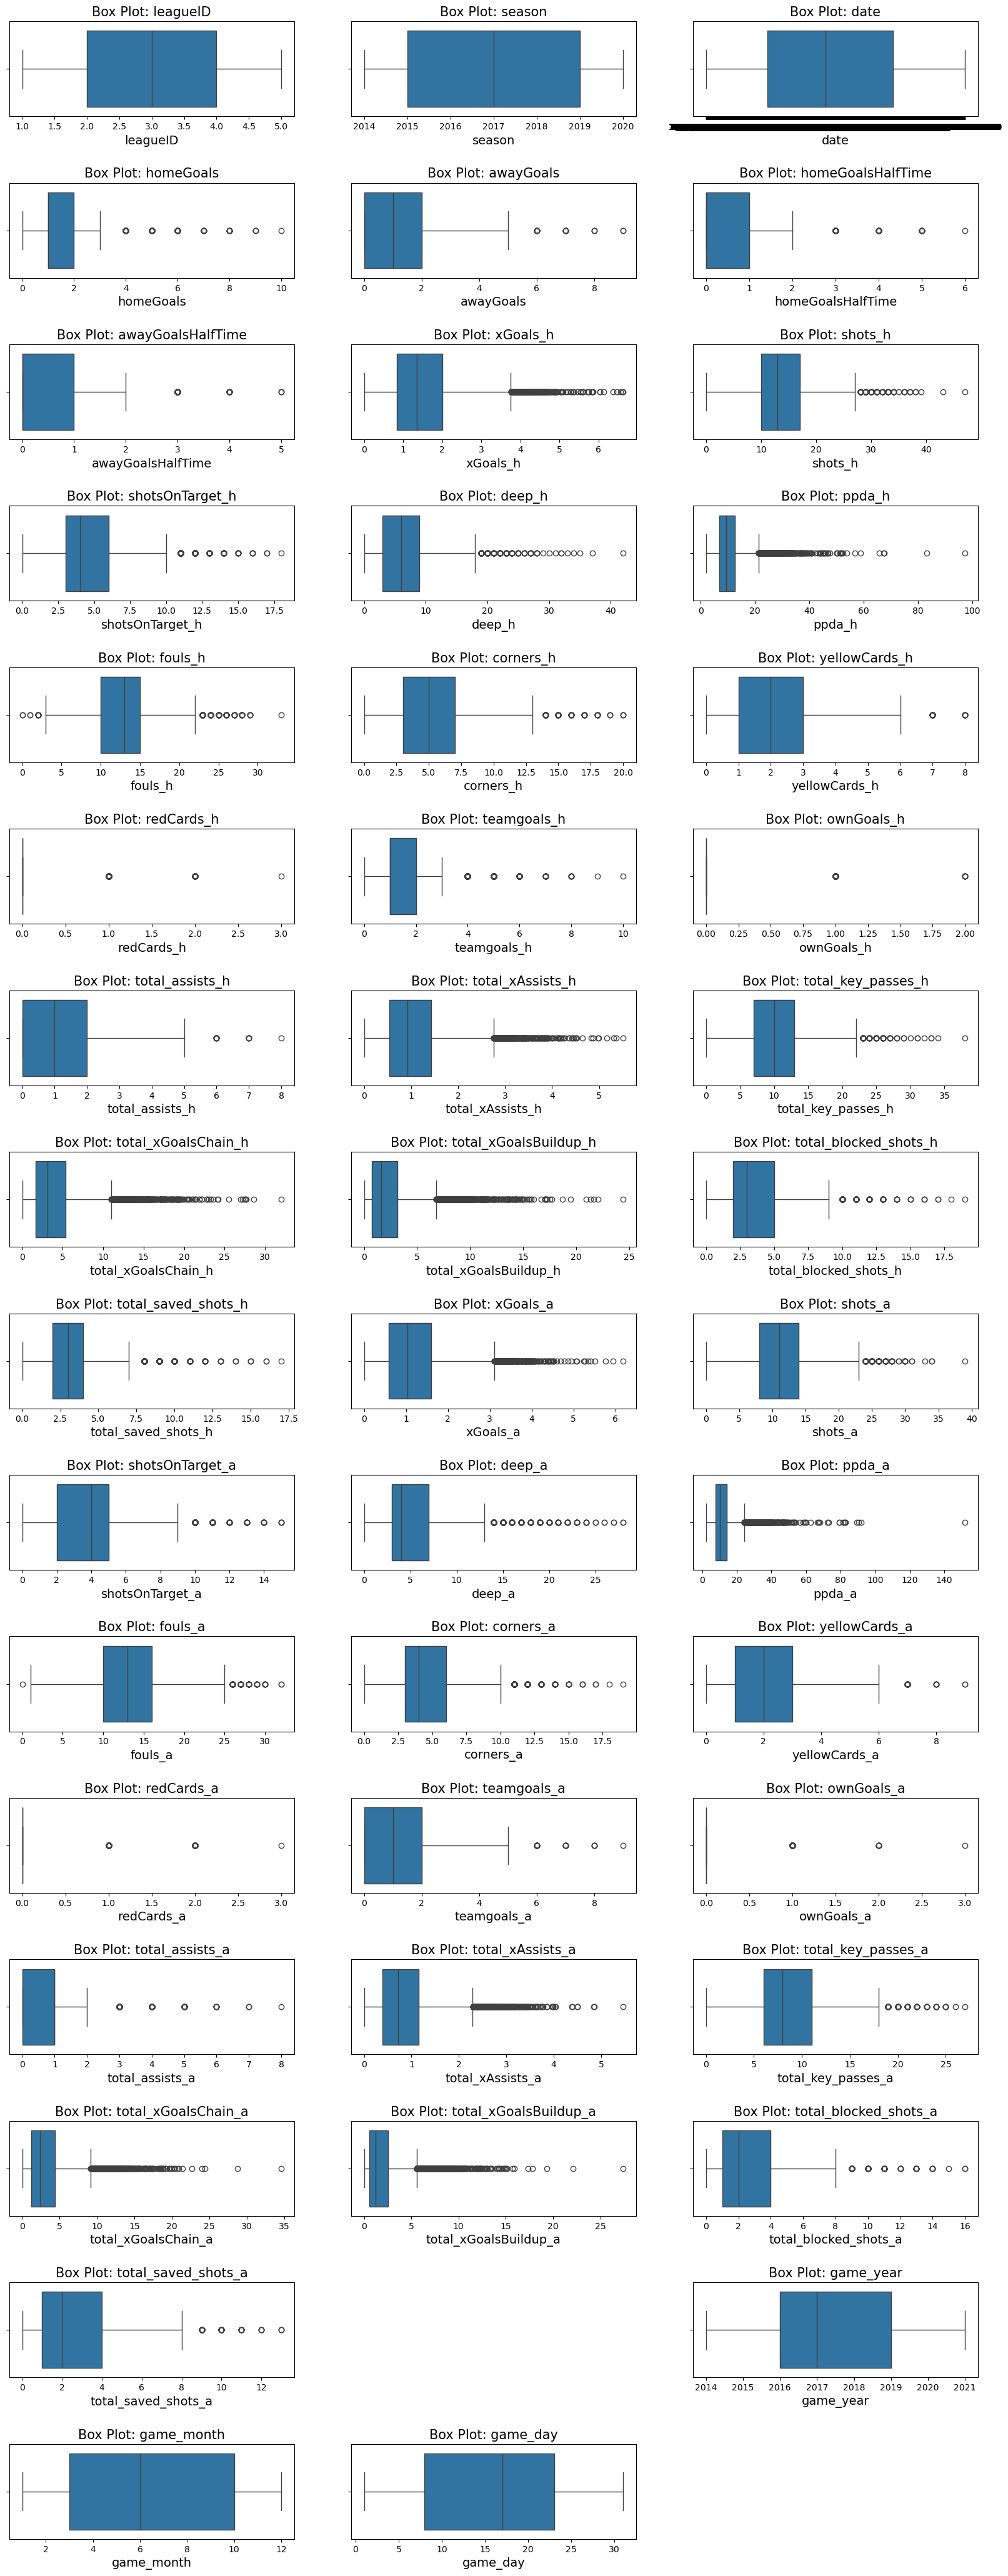

In [13]:
outliers
plt.show()

# Nulls matrix

In [14]:
df_nulls = df.copy()
for col in df_nulls:
    if df_nulls[col].isna().sum() == 0:
        del df_nulls[col]
df_nulls

,yellowCards_h,total_blocked_shots_h,total_saved_shots_h,total_blocked_shots_a,total_saved_shots_a
0,2.0,4.0,1.0,3.0,4.0
1,3.0,2.0,2.0,2.0,2.0
2,1.0,2.0,3.0,3.0,3.0
3,2.0,4.0,4.0,2.0,3.0
4,1.0,3.0,4.0,2.0,4.0
...,...,...,...,...,...
12675,2.0,6.0,4.0,1.0,3.0
12676,1.0,3.0,2.0,4.0,3.0
12677,1.0,2.0,4.0,0.0,2.0
12678,1.0,5.0,5.0,1.0,1.0


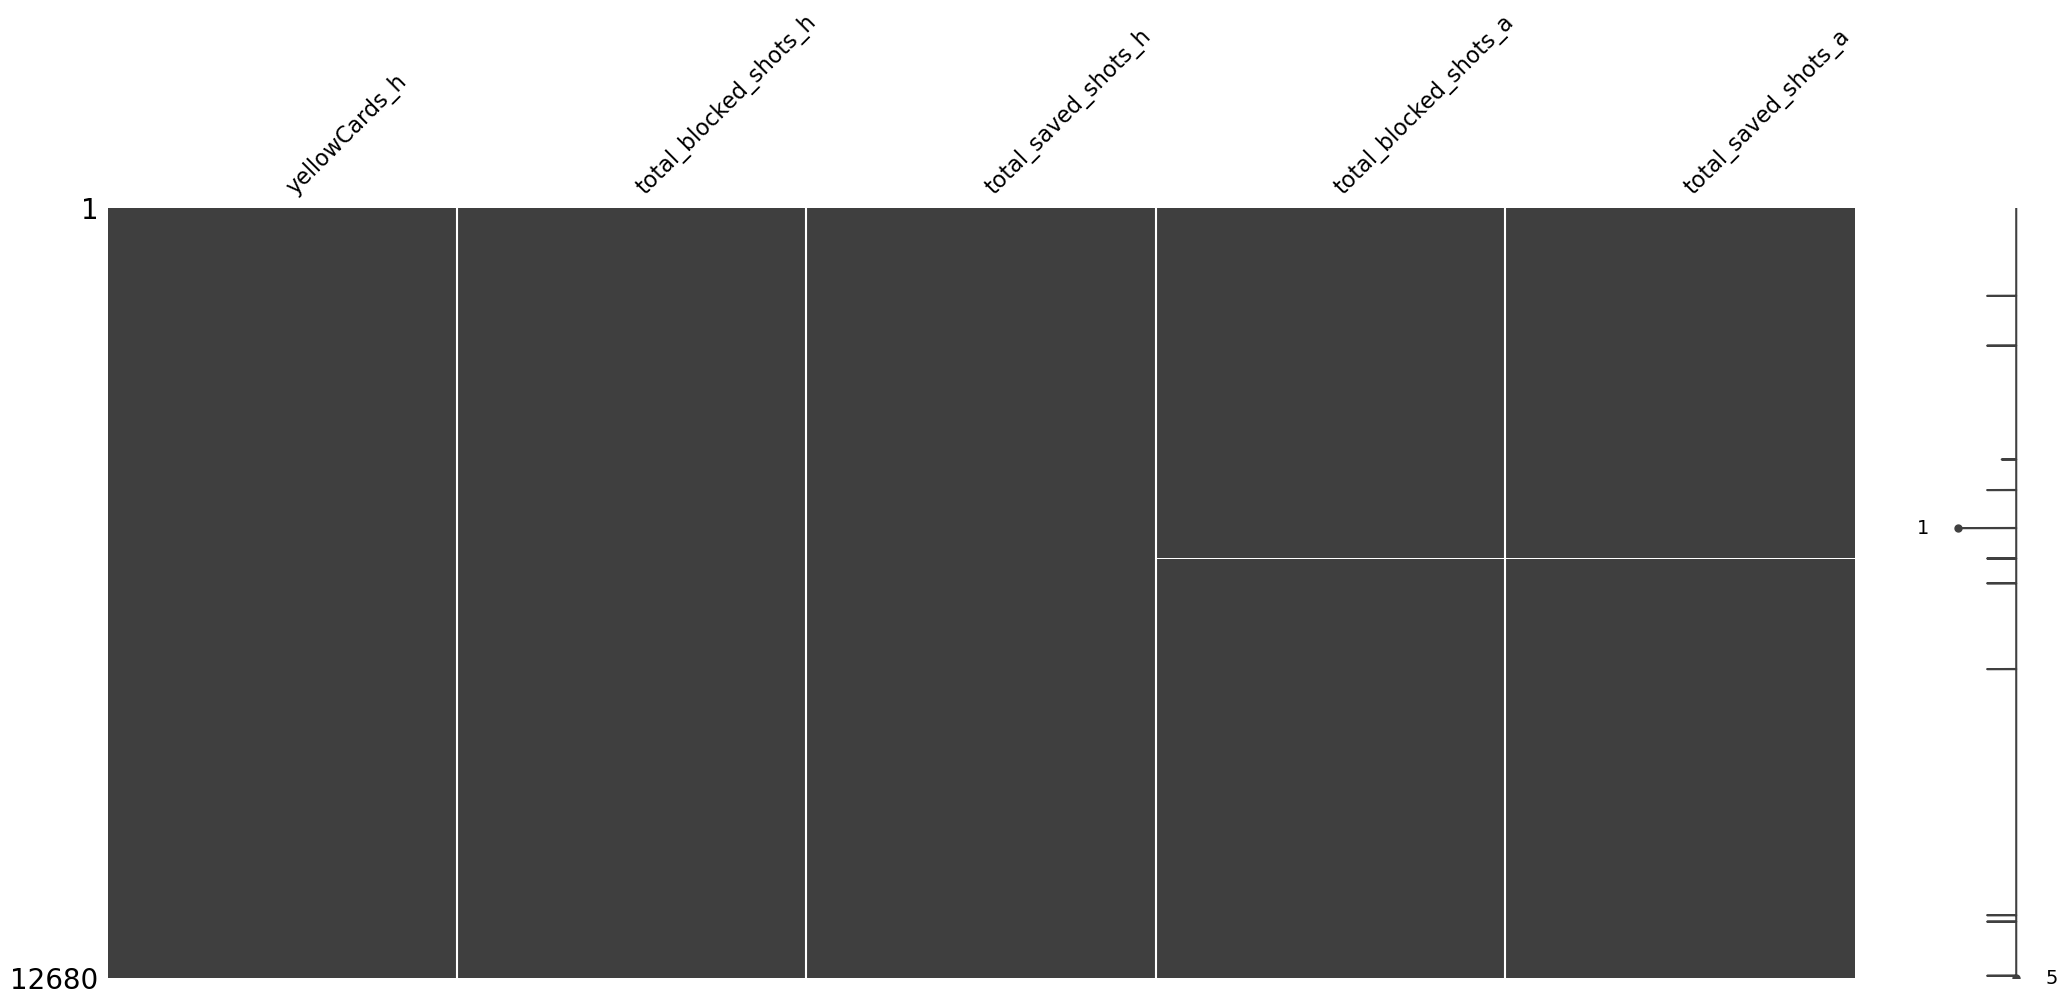

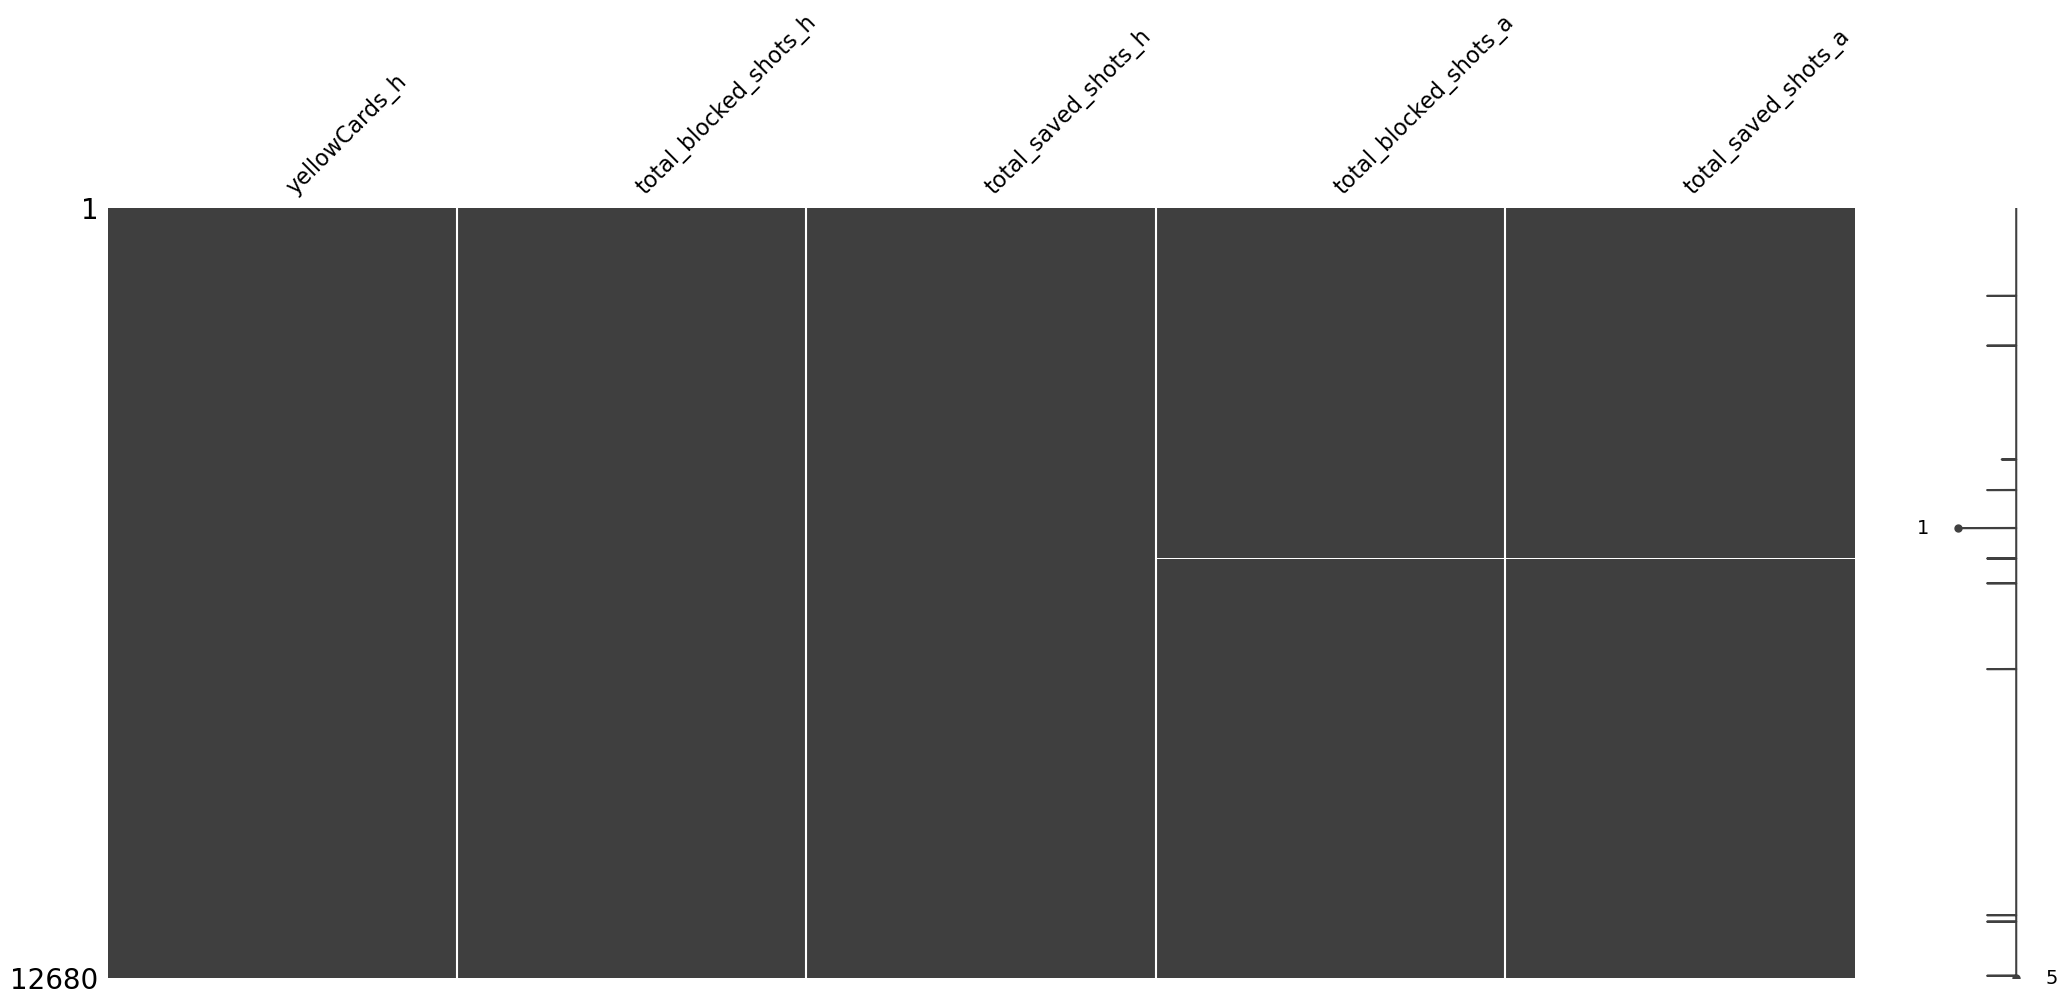

In [17]:
#%pip install missingno
import missingno as msno
msno.matrix(df_nulls)
plt.show()

#### Dataframe containing missing value counts and their frequency:

In [18]:
mis_val = df_nulls.isna().sum()
mis_val_per = df_nulls.isna().sum()/len(df_nulls)*100
mis_val_table = pd.concat([mis_val, mis_val_per], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,:] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
mis_val_table_ren_columns

,Missing Values,% of Total Values
total_blocked_shots_a,8,0.1
total_saved_shots_a,8,0.1
total_blocked_shots_h,3,0.0
total_saved_shots_h,3,0.0
yellowCards_h,1,0.0


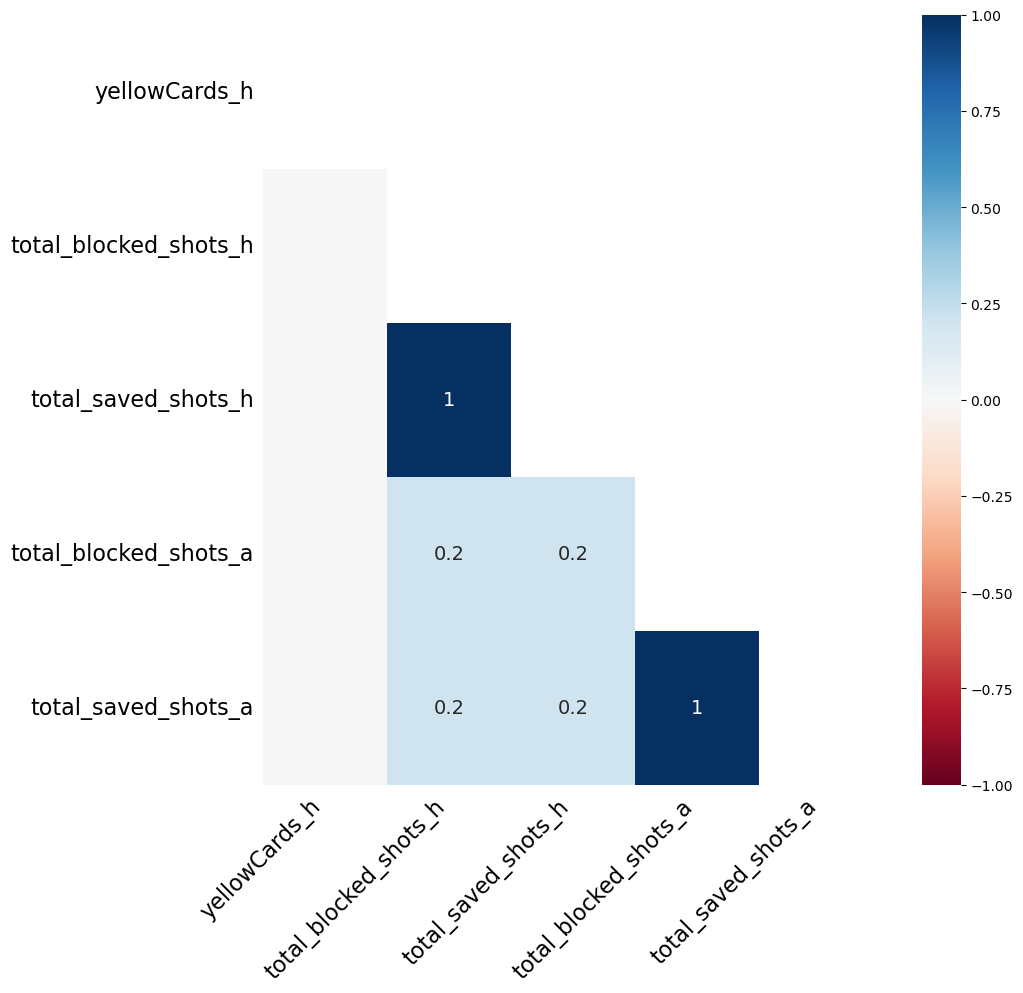

In [22]:
## missingness correlation heatmap
msno.heatmap(df_nulls,figsize=(10,10))
plt.show()

### Outliers Analysis

In [31]:
# Define the outlier detection function
def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])  # Fix column definition
    for col in df:
        if col != 'result_h' and df[col].dtype in ['int64', 'float64']:  # Ensure numeric columns only
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_limit = Q3 + 1.5 * IQR
            lower_limit = Q1 - 1.5 * IQR
            num_outliers = ((df[col] > upper_limit) | (df[col] < lower_limit)).sum()
            percent_outliers = (num_outliers / len(df)) * 100
            total_outliers.loc[col] = [num_outliers, percent_outliers]
    
    return total_outliers[total_outliers['Percent'] > 0]

# Run the function on the dataset
outliers_result = outliers_df(df_base).sort_values('Percent', ascending=False)
outliers_result


,Outlier count,Percent
redCards_a,1396.0,11.009464
redCards_h,1078.0,8.501577
homeGoals,981.0,7.736593
teamgoals_h,917.0,7.231861
total_assists_a,790.0,6.230284
total_xGoalsBuildup_a,718.0,5.662461
total_xGoalsBuildup_h,664.0,5.236593
ppda_a,606.0,4.779180
ownGoals_a,563.0,4.440063
ppda_h,540.0,4.258675


In [32]:
outliers_result.to_csv(path_result+'/'+'outliers_df.csv')

In [40]:
def capping(df,outliers_result):
    temp = df.copy()
    for col in temp:
        if col in outliers_result.index:
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            upper_limit = Q1 + 1.5 * (Q3-Q1)
            lower_limit = Q3 - 1.5 * (Q3-Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df_base,outliers_result)
temp

,leagueID,season,date,homeGoals,awayGoals,homeGoalsHalfTime,awayGoalsHalfTime,xGoals_h,shots_h,shotsOnTarget_h,deep_h,ppda_h,fouls_h,corners_h,yellowCards_h,redCards_h,teamgoals_h,ownGoals_h,total_assists_h,total_xAssists_h,total_key_passes_h,total_xGoalsChain_h,total_xGoalsBuildup_h,total_blocked_shots_h,total_saved_shots_h,xGoals_a,shots_a,shotsOnTarget_a,deep_a,ppda_a,fouls_a,corners_a,yellowCards_a,redCards_a,teamgoals_a,ownGoals_a,total_assists_a,total_xAssists_a,total_key_passes_a,total_xGoalsChain_a,total_xGoalsBuildup_a,total_blocked_shots_a,total_saved_shots_a,result_h,game_year,game_month,game_day
0,1,2015,8/8/2015 15:45,1.0,0.0,1.0,0.0,0.627539,9.0,NaN,4.0,13.8261,12.0,1.0,2.0,0.0,NaN,0.0,0.0,0.284979,5.0,1.396328,0.994160,4.0,1.0,0.674600,9.0,4.0,NaN,8.2188,12.0,2.0,3.0,0.0,0.0,NaN,0.0,0.586365,7.0,1.745371,0.811549,3.0,4.0,W,2015,8,8
1,1,2015,8/8/2015 18:00,NaN,1.0,0.0,0.0,0.876106,11.0,2.0,11.0,6.9000,13.0,6.0,3.0,0.0,NaN,0.0,0.0,0.419975,9.0,2.159510,1.170894,2.0,2.0,0.782253,7.0,3.0,2.0,11.8462,13.0,3.0,4.0,0.0,1.0,0.0,1.0,0.560695,4.0,1.238205,0.736815,2.0,2.0,L,2015,8,8
2,1,2015,8/8/2015 18:00,2.0,2.0,0.0,1.0,0.604226,10.0,5.0,5.0,6.6500,NaN,8.0,1.0,0.0,2.0,0.0,2.0,0.549139,8.0,1.025550,0.493522,2.0,3.0,0.557892,11.0,5.0,4.0,17.1579,13.0,2.0,2.0,0.0,2.0,0.0,1.0,0.418385,8.0,1.959323,1.030588,3.0,3.0,D,2015,8,8
3,1,2015,8/8/2015 18:00,NaN,2.0,NaN,0.0,2.568030,19.0,NaN,5.0,10.8800,13.0,6.0,2.0,0.0,NaN,0.0,2.0,1.727543,NaN,6.815649,3.741916,4.0,4.0,1.459460,11.0,5.0,6.0,9.5556,17.0,3.0,4.0,0.0,2.0,0.0,NaN,1.288886,9.0,NaN,NaN,2.0,3.0,W,2015,8,8
4,1,2015,8/8/2015 18:00,1.0,3.0,0.0,1.0,1.130760,17.0,6.0,5.0,5.7368,14.0,1.0,1.0,0.0,1.0,0.0,1.0,0.416638,12.0,1.966623,0.699249,3.0,4.0,NaN,11.0,NaN,NaN,10.6250,NaN,4.0,0.0,0.0,3.0,0.0,NaN,NaN,10.0,NaN,NaN,2.0,4.0,L,2015,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,5,2020,5/23/2021 19:00,1.0,2.0,1.0,1.0,1.411190,15.0,5.0,NaN,12.3684,8.0,9.0,2.0,0.0,1.0,0.0,1.0,0.971853,11.0,3.853730,1.999150,6.0,4.0,1.707510,8.0,5.0,3.0,8.3529,11.0,5.0,2.0,0.0,2.0,0.0,1.0,0.307960,4.0,1.223212,0.715843,1.0,3.0,L,2021,5,23
12676,5,2020,5/23/2021 19:00,1.0,2.0,1.0,1.0,1.198190,10.0,3.0,3.0,NaN,11.0,5.0,1.0,0.0,1.0,0.0,1.0,0.855524,8.0,1.962812,1.028432,3.0,2.0,1.238050,12.0,5.0,4.0,NaN,NaN,2.0,1.0,0.0,2.0,0.0,1.0,0.775388,7.0,2.610665,1.758012,4.0,3.0,L,2021,5,23
12677,5,2020,5/23/2021 19:00,2.0,0.0,1.0,0.0,1.332690,12.0,6.0,10.0,8.2857,11.0,4.0,1.0,0.0,2.0,0.0,1.0,1.151649,8.0,NaN,NaN,2.0,4.0,0.357583,9.0,2.0,NaN,NaN,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.216965,6.0,0.884652,0.544502,0.0,2.0,W,2021,5,23
12678,5,2020,5/23/2021 19:00,NaN,1.0,0.0,1.0,1.460500,19.0,5.0,6.0,7.5600,13.0,9.0,1.0,0.0,NaN,0.0,0.0,1.265829,13.0,4.790546,3.092978,5.0,5.0,1.380290,10.0,2.0,3.0,14.7200,10.0,3.0,0.0,0.0,1.0,0.0,1.0,0.565077,6.0,1.256511,0.764512,1.0,1.0,L,2021,5,23


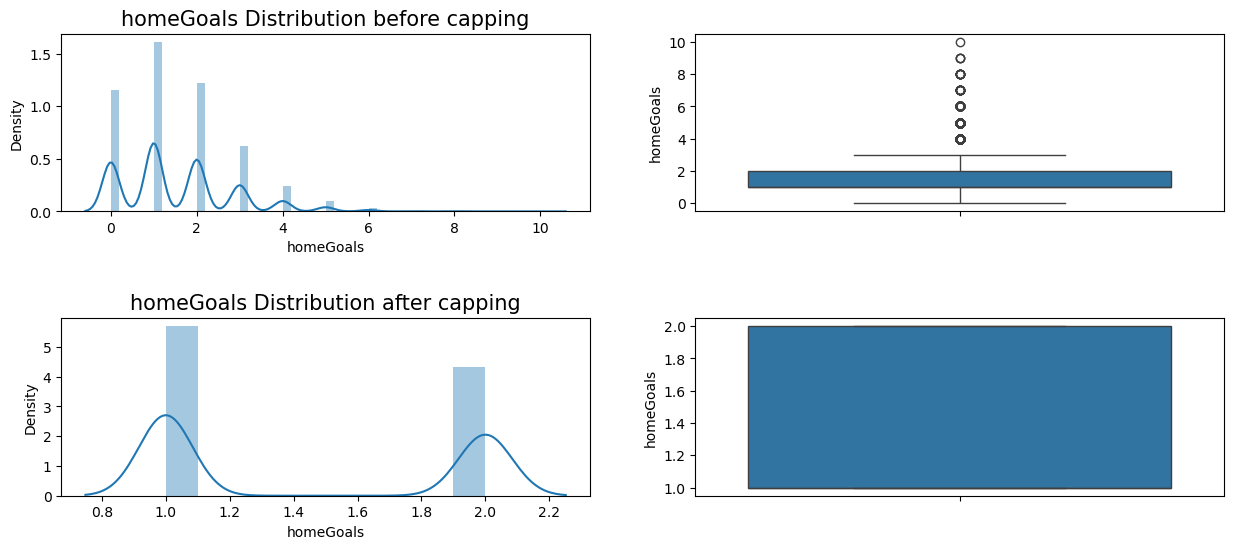

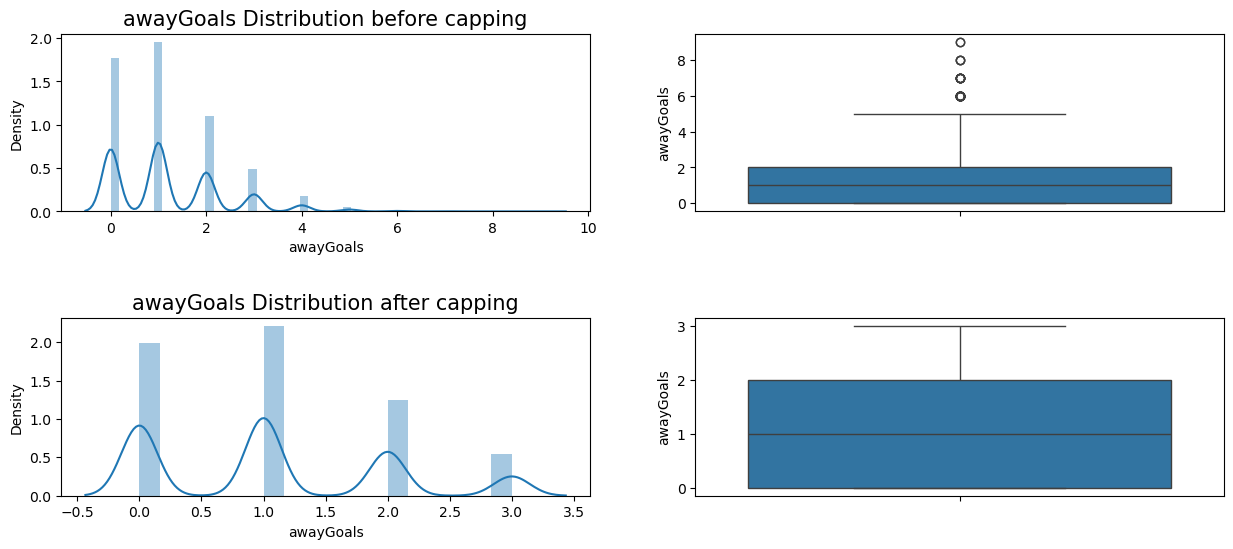

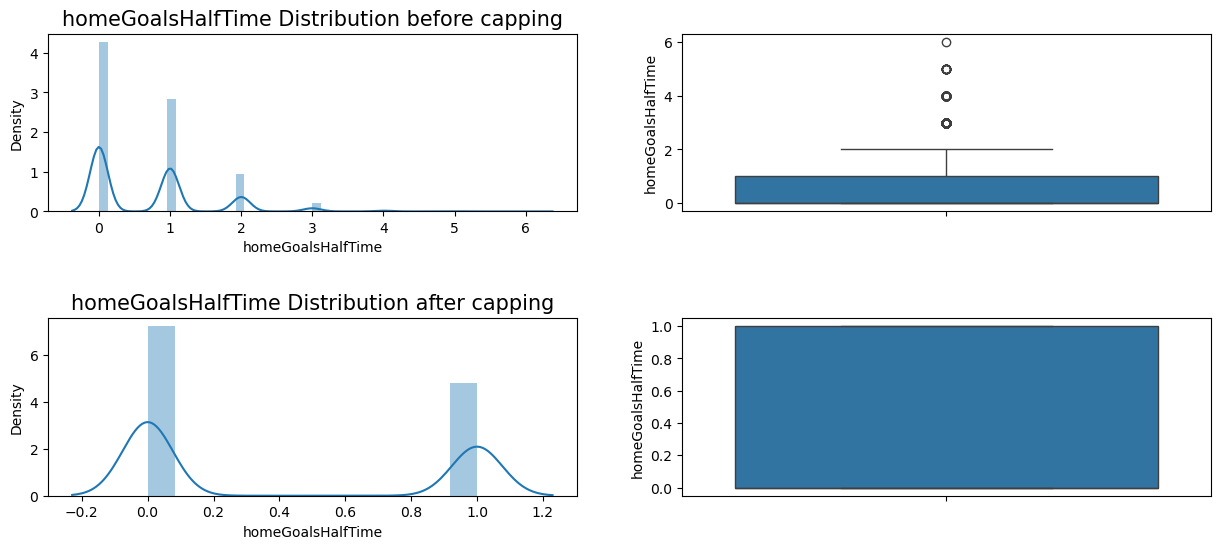

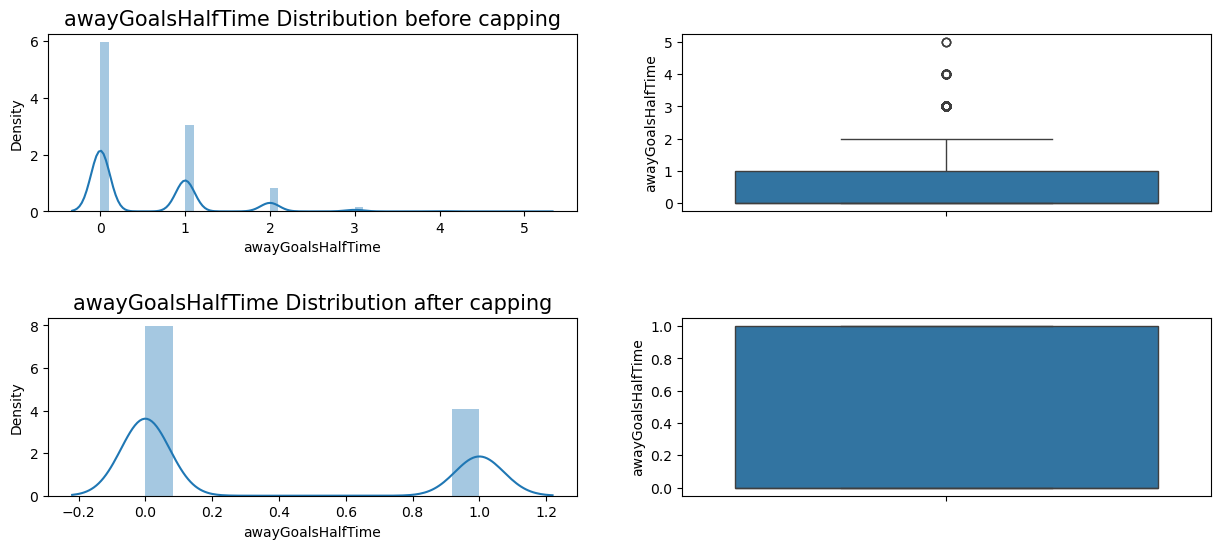

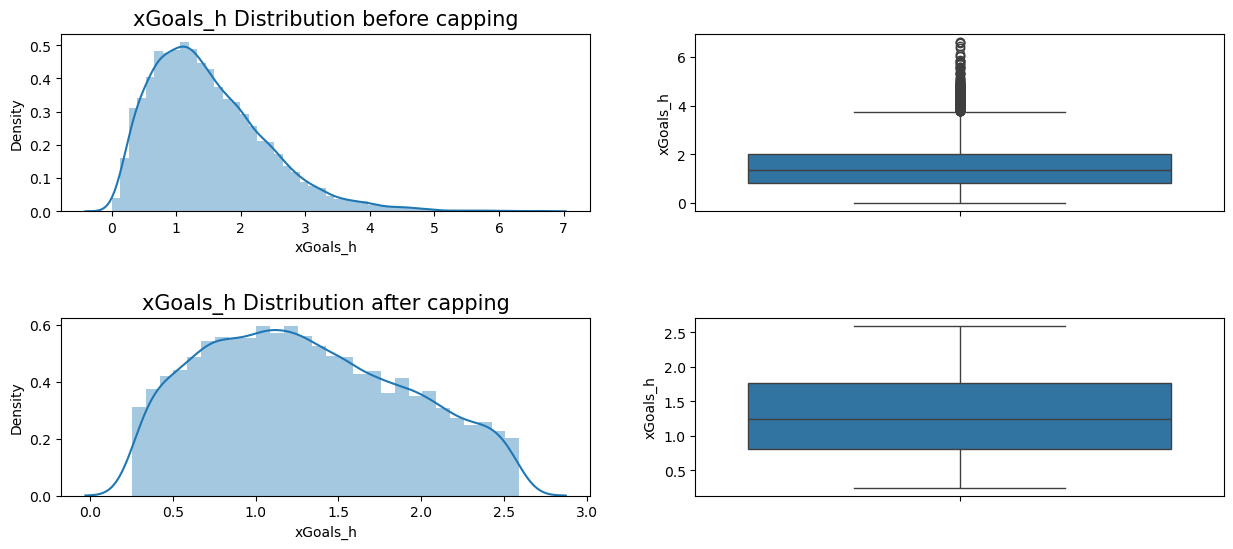

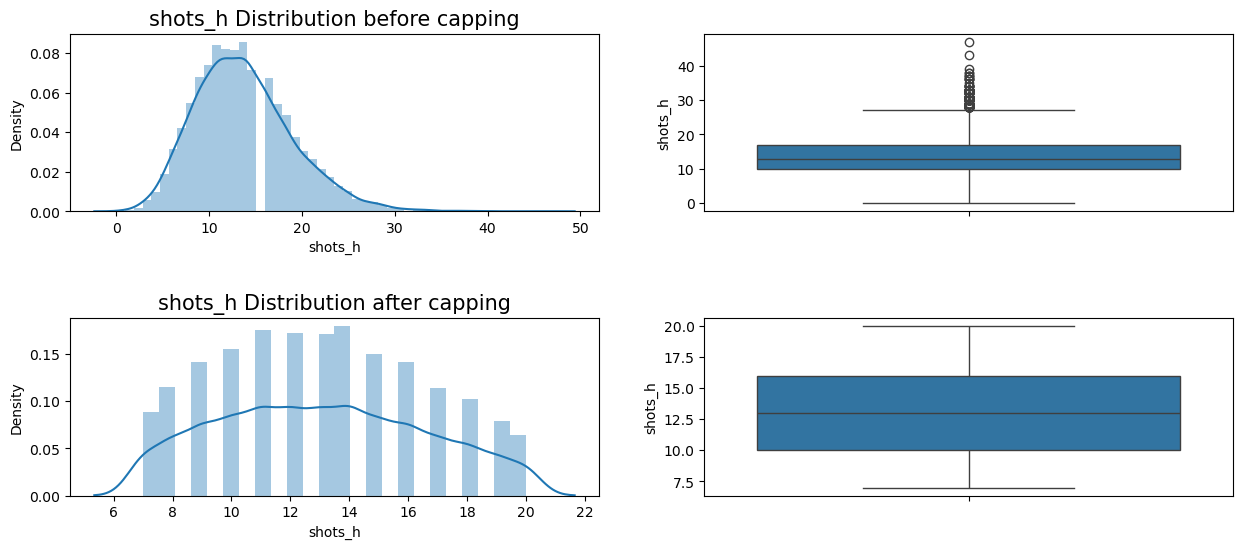

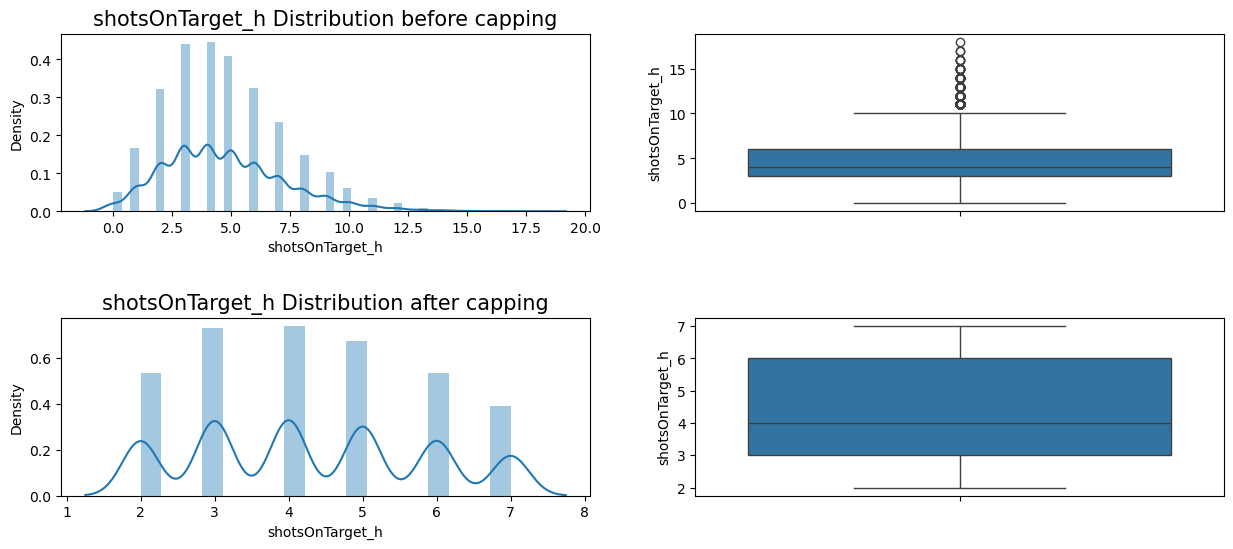

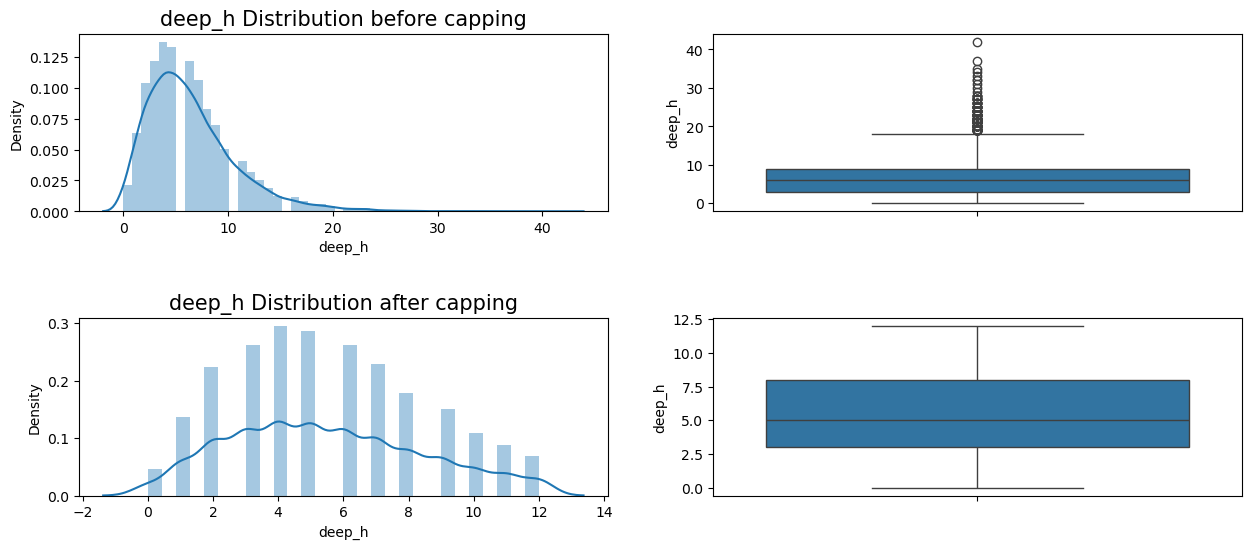

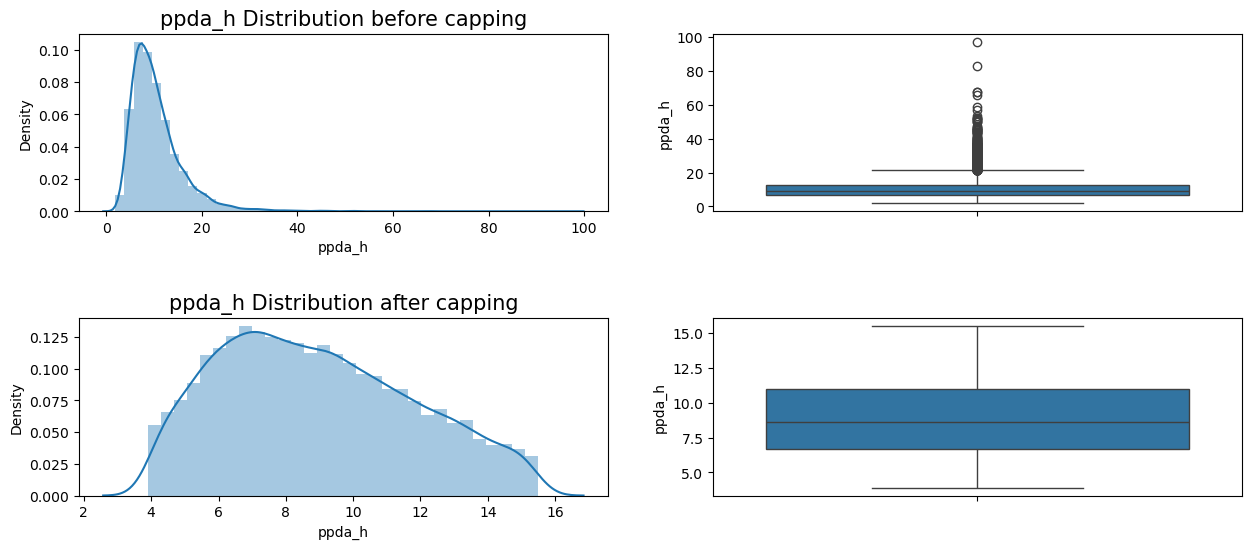

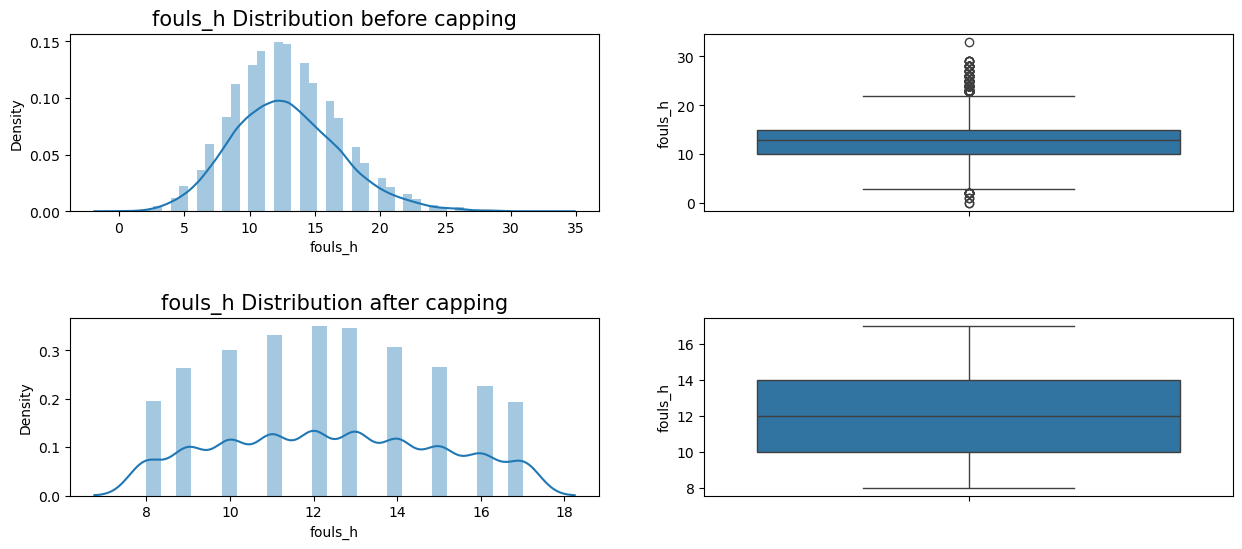

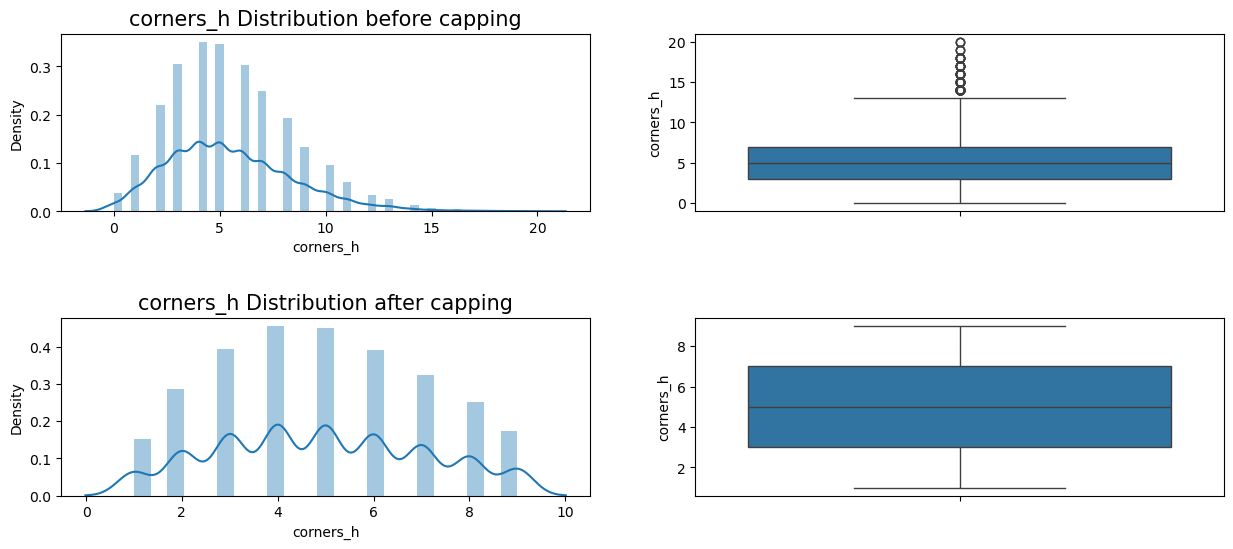

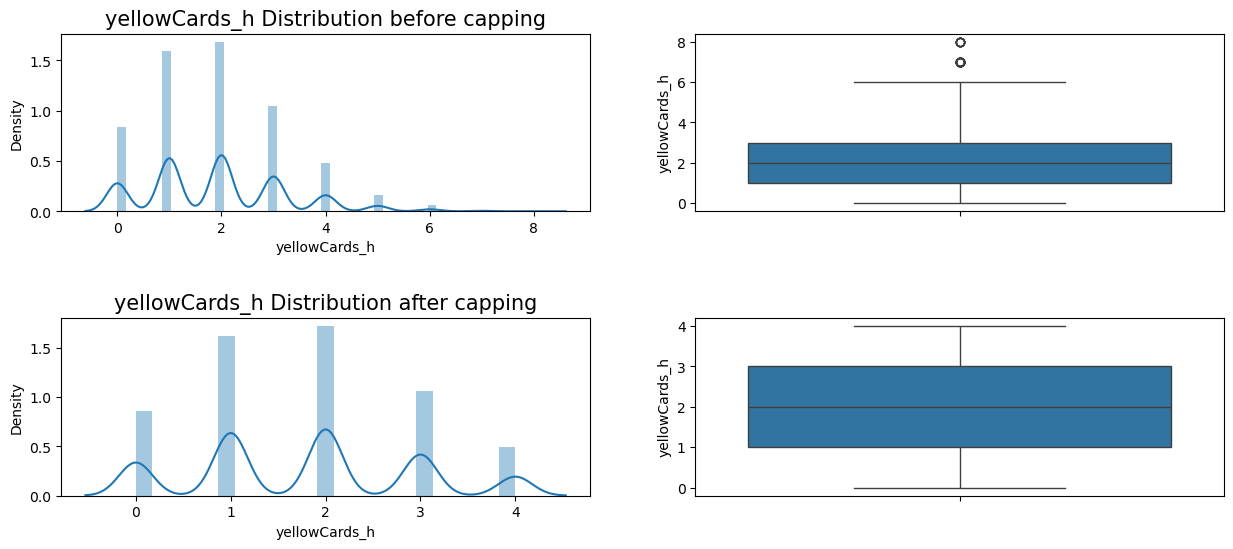

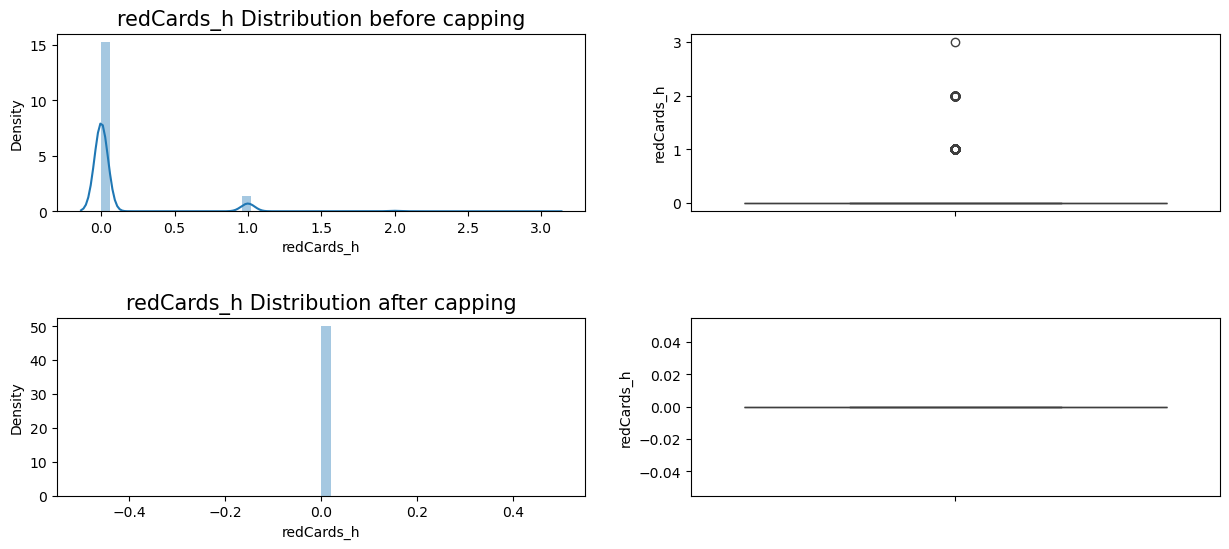

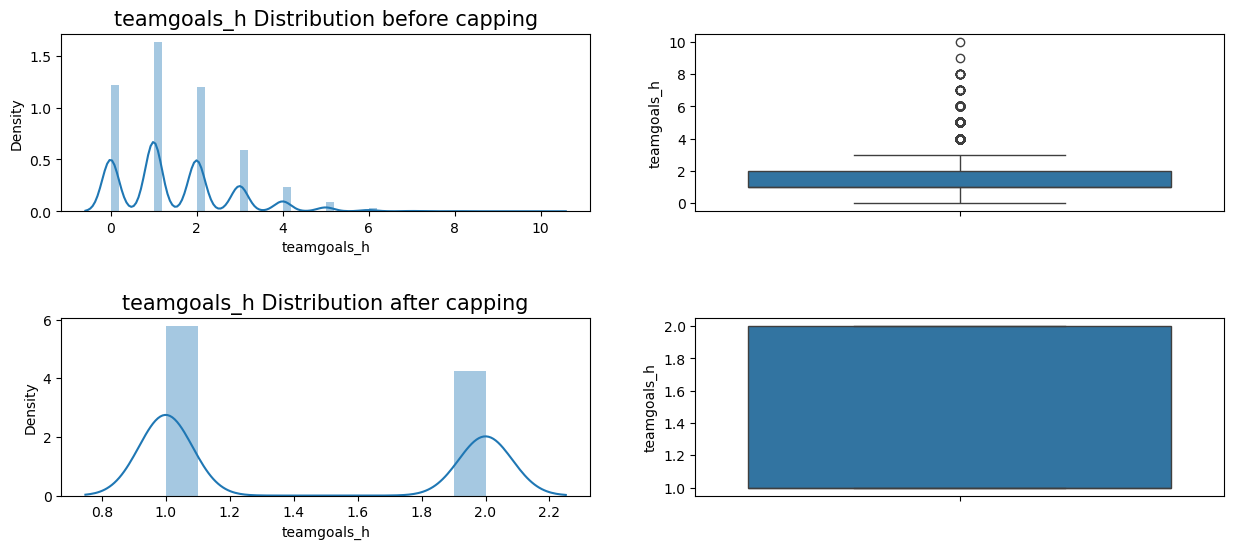

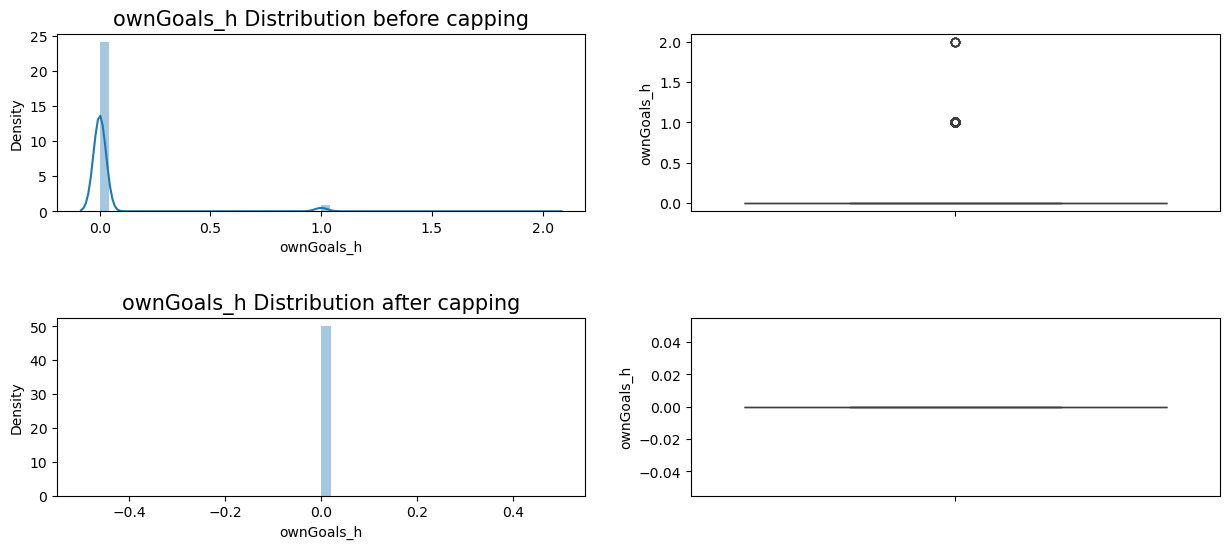

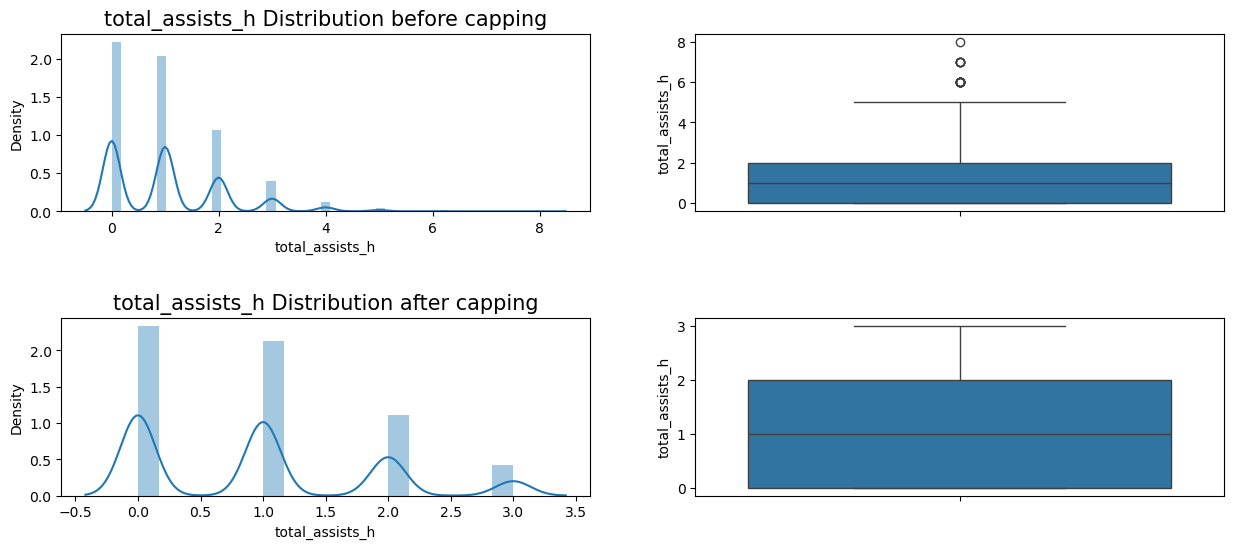

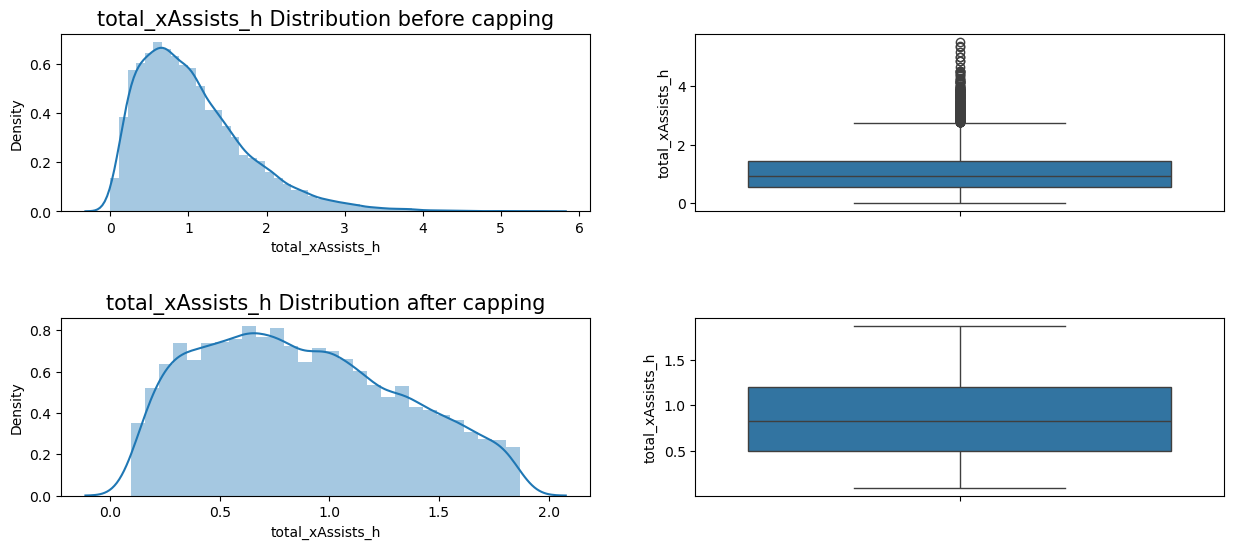

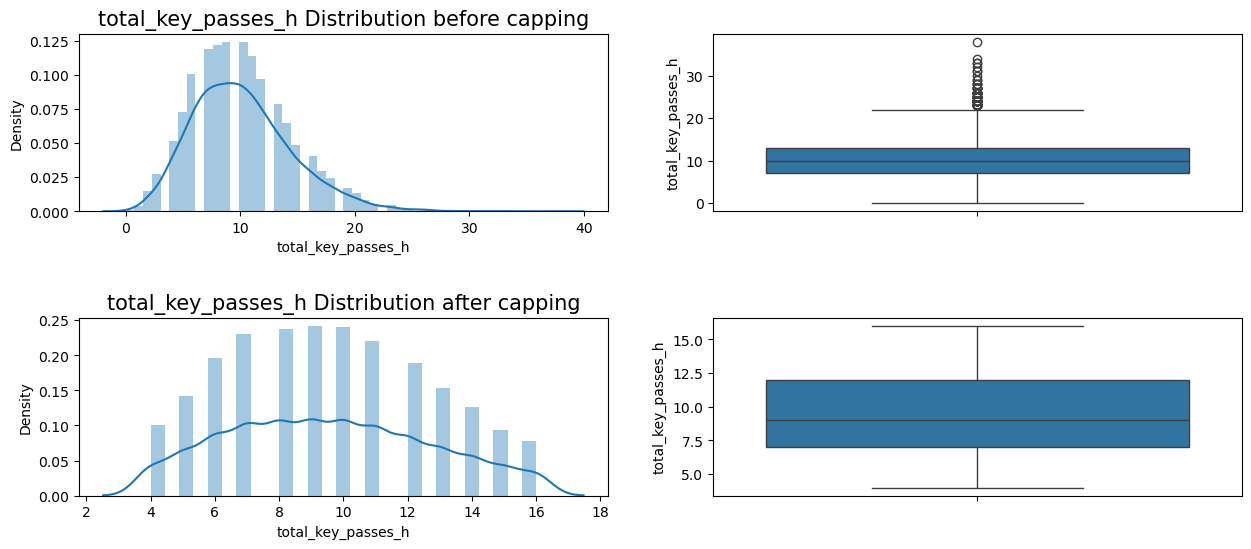

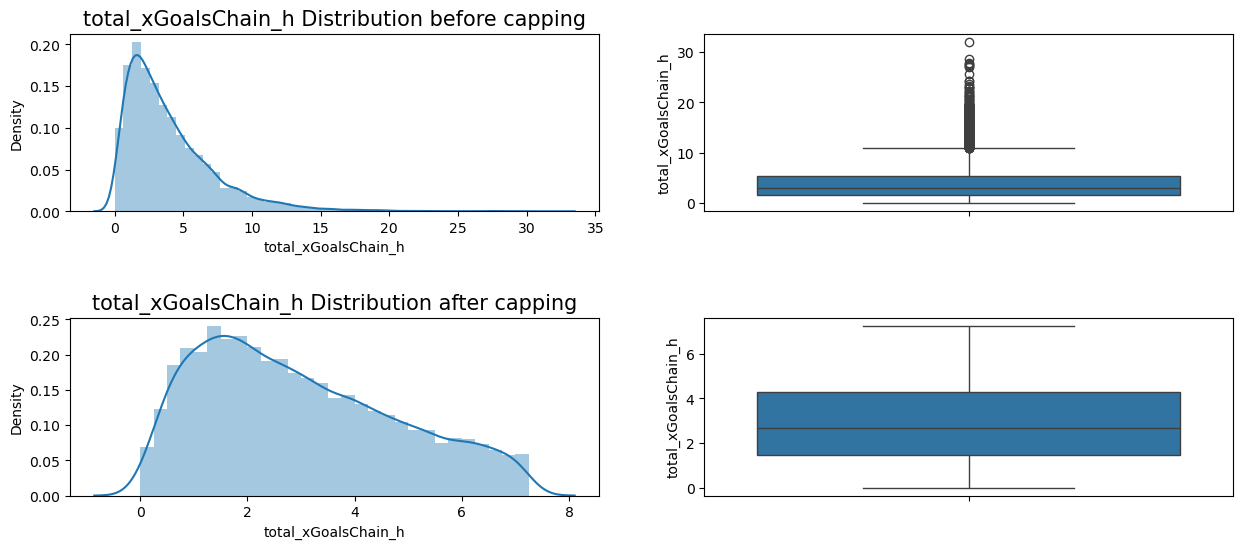

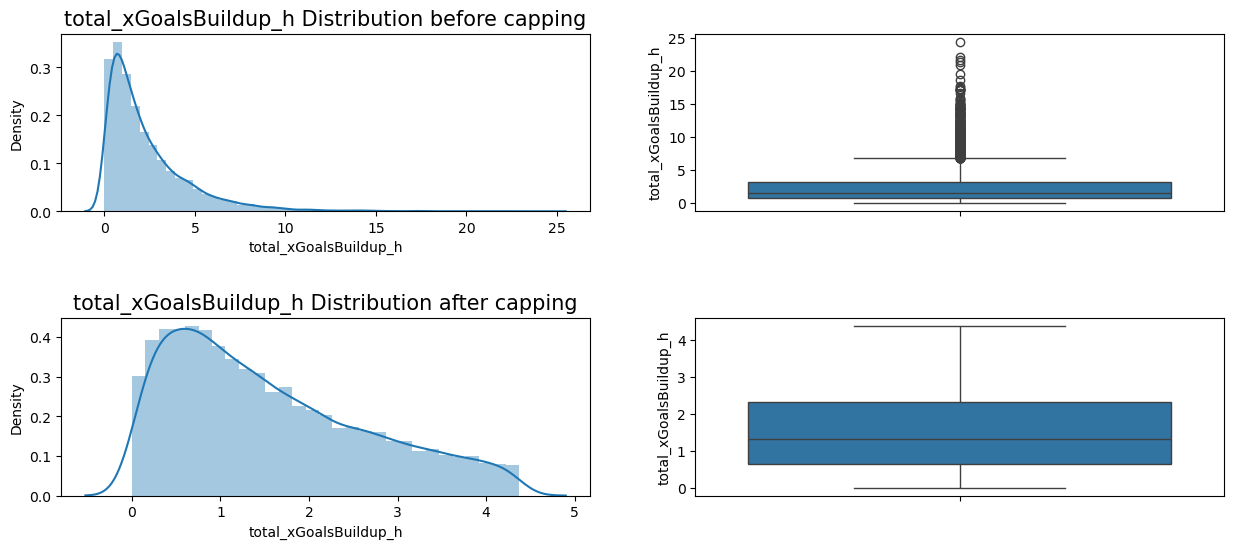

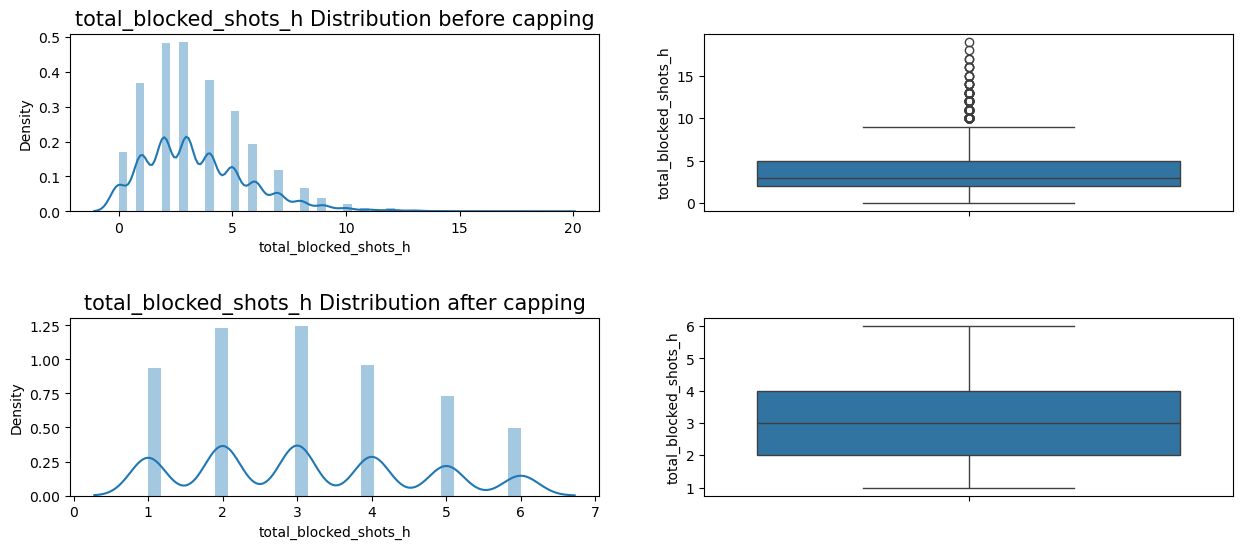

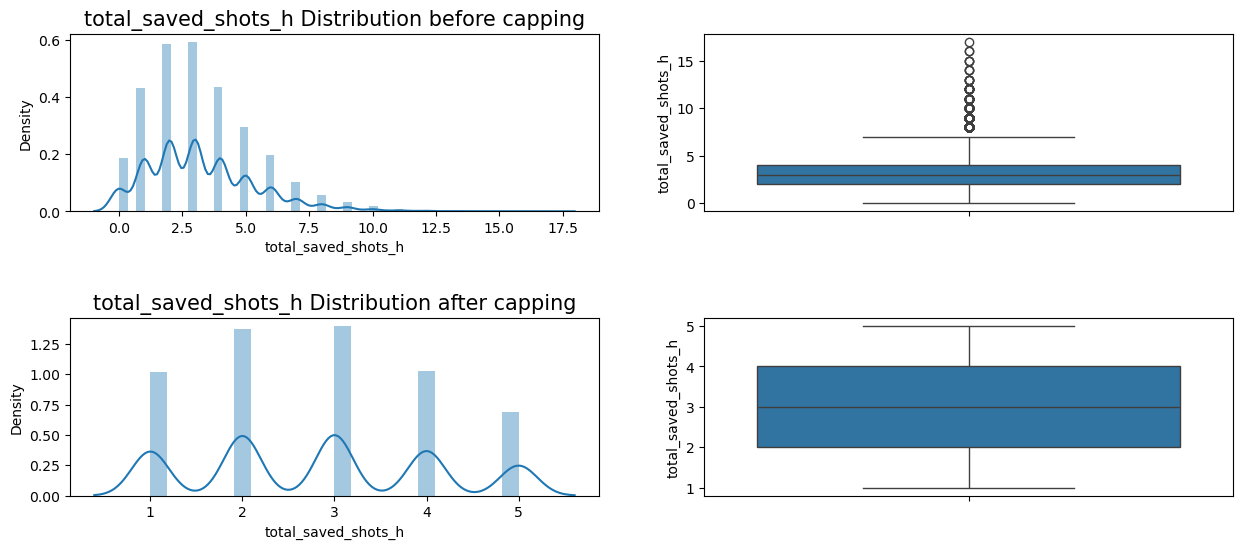

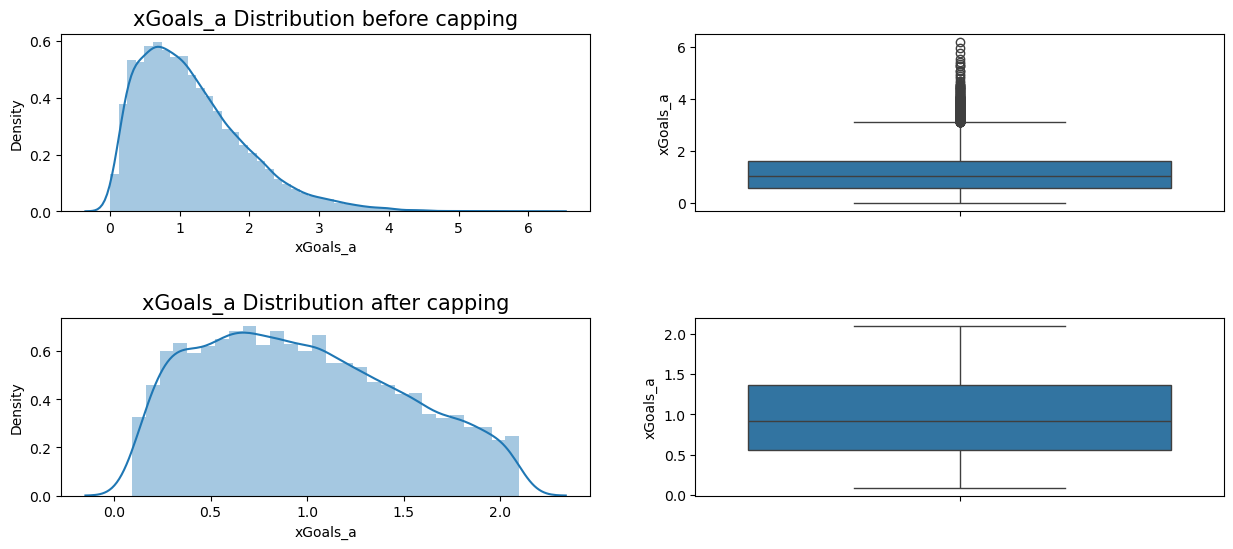

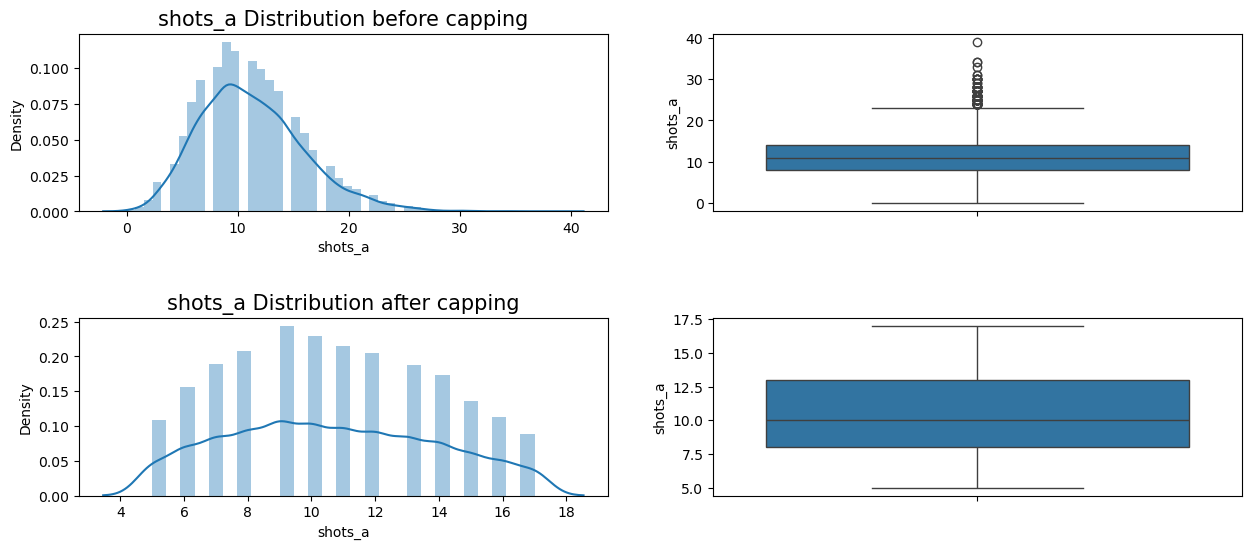

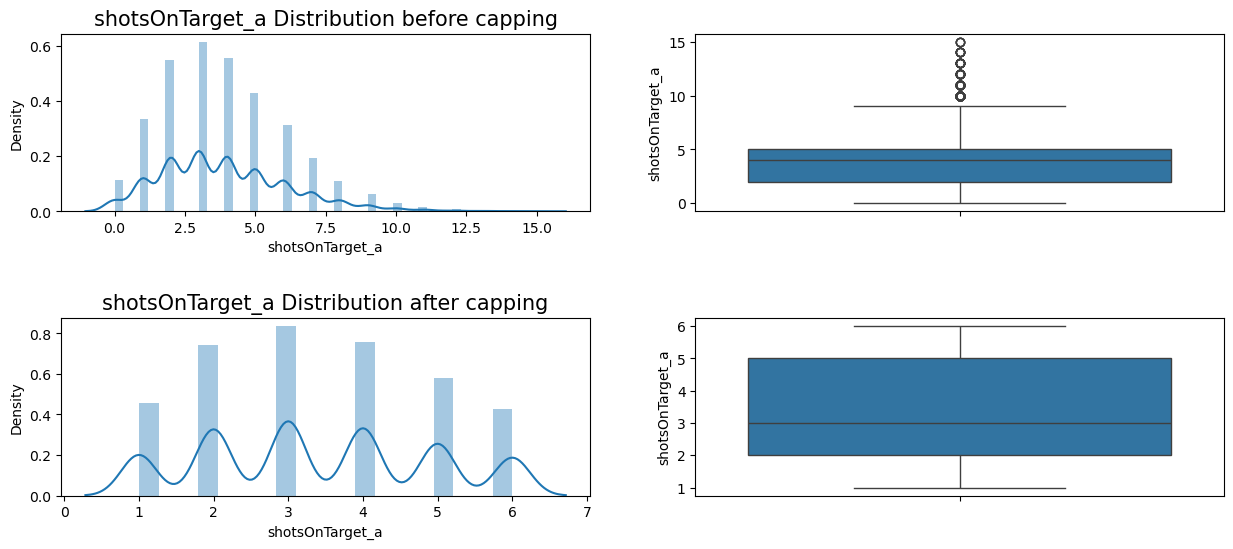

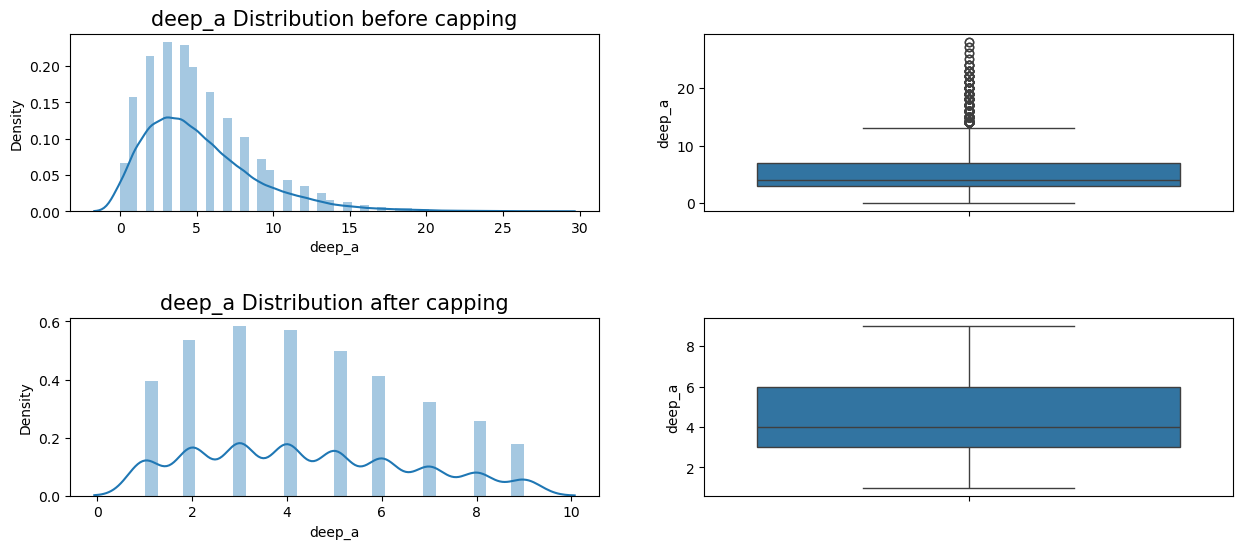

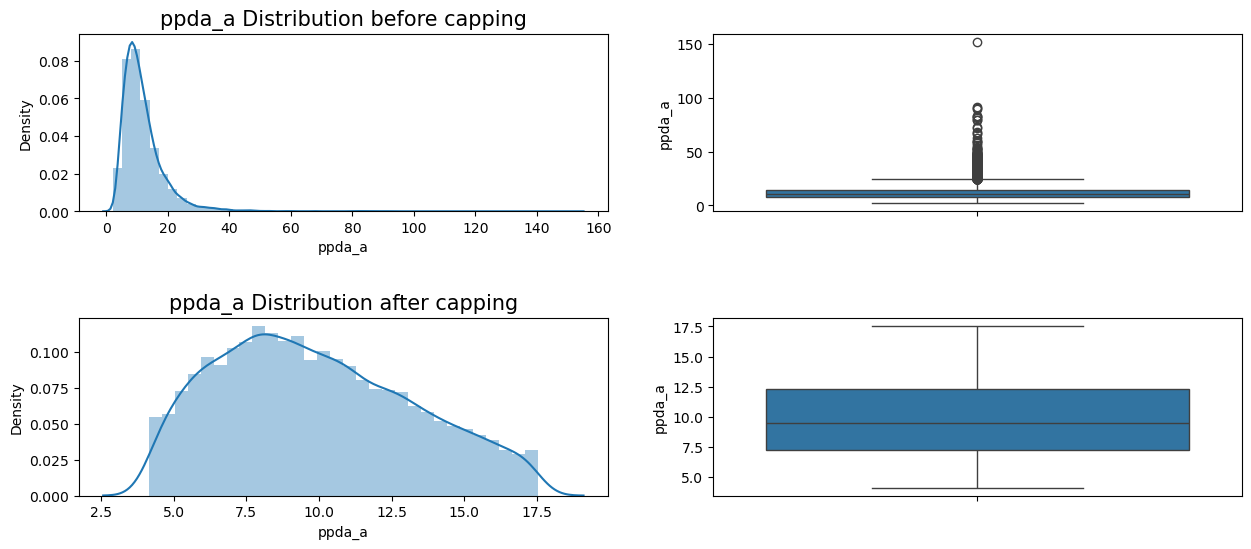

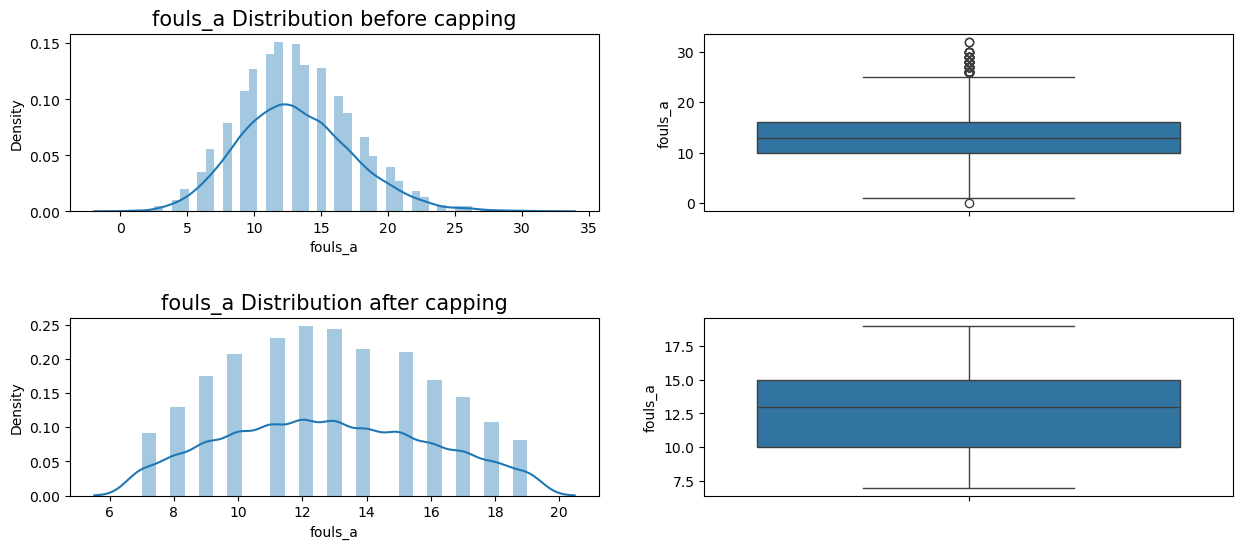

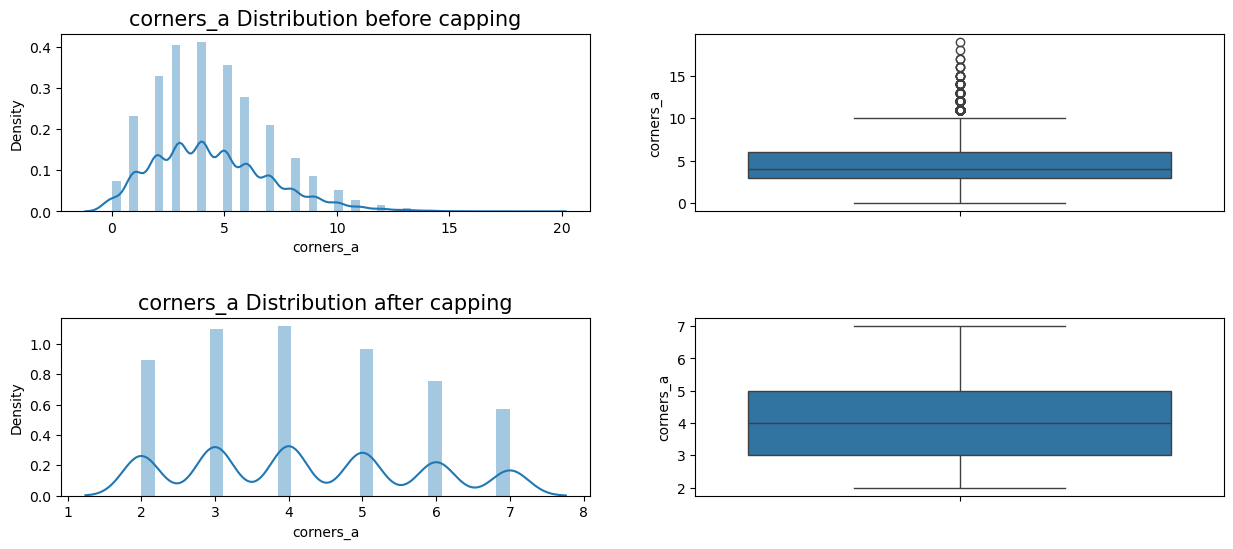

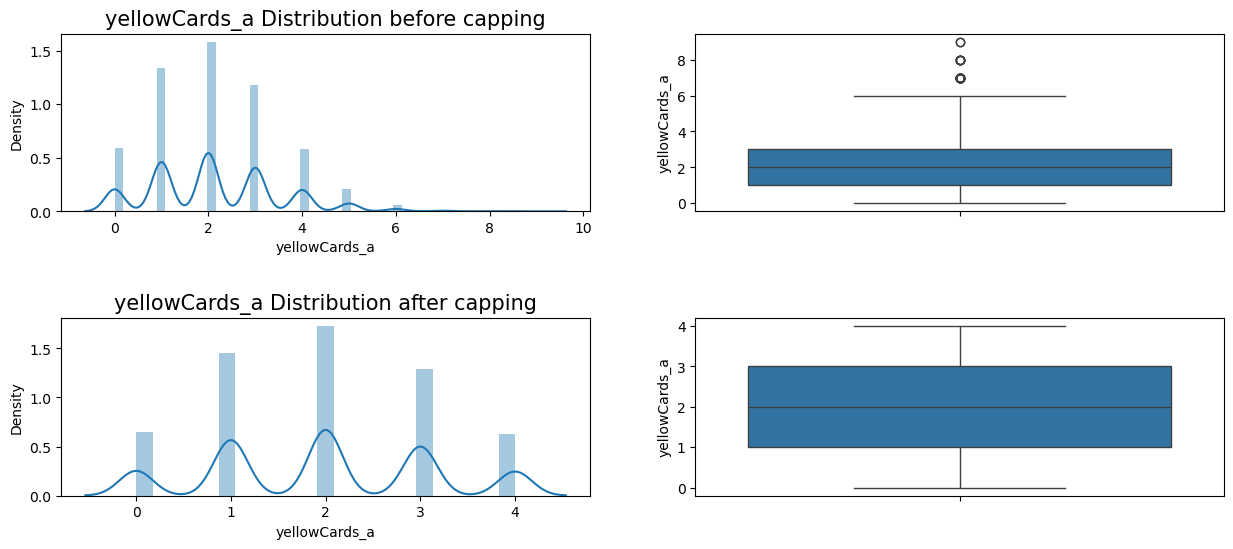

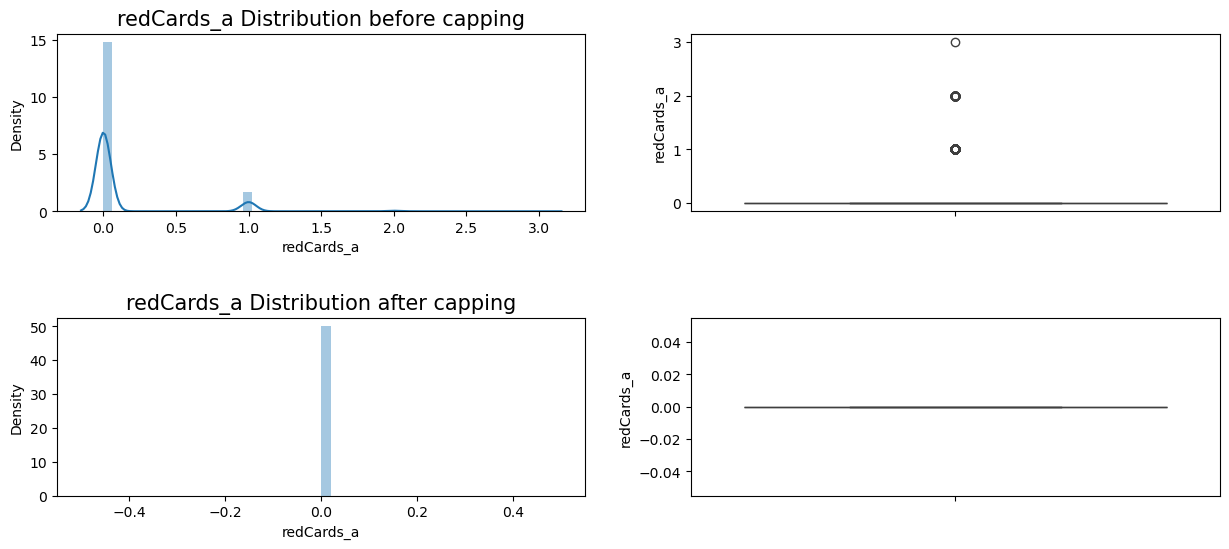

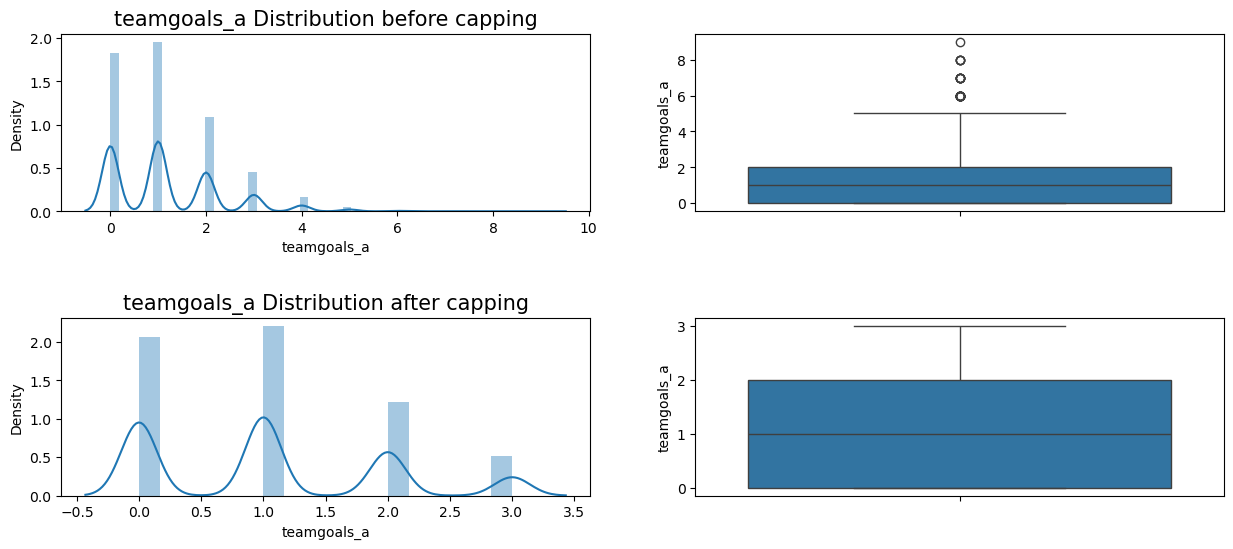

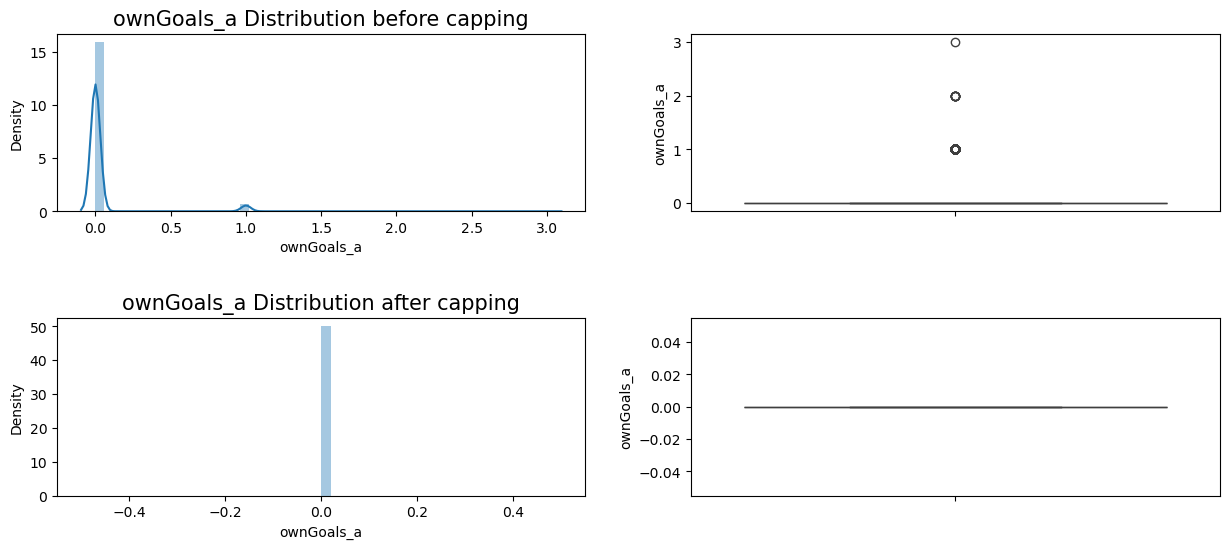

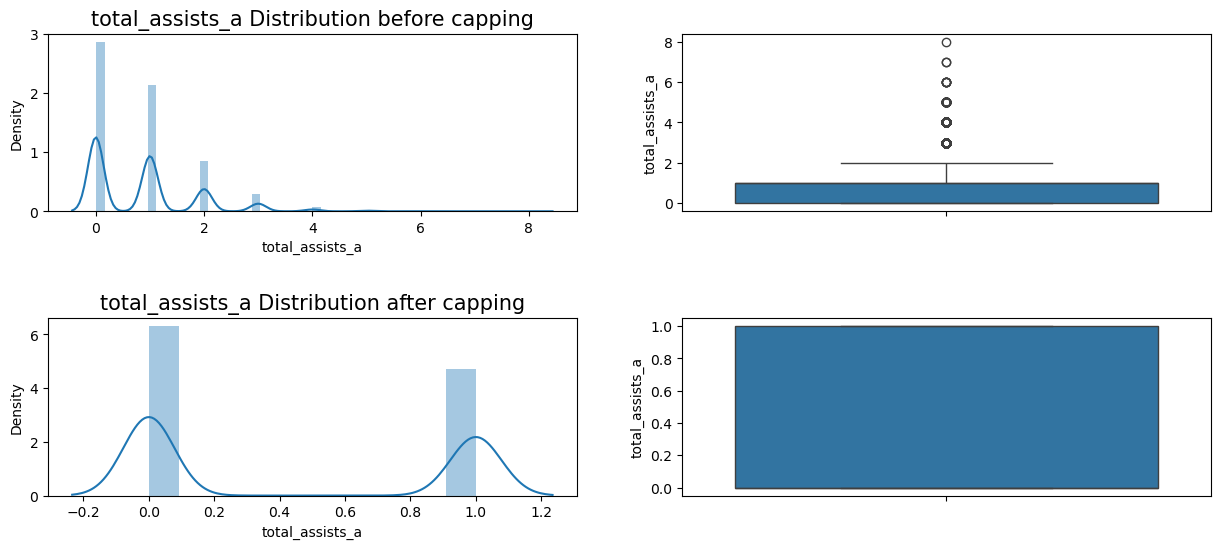

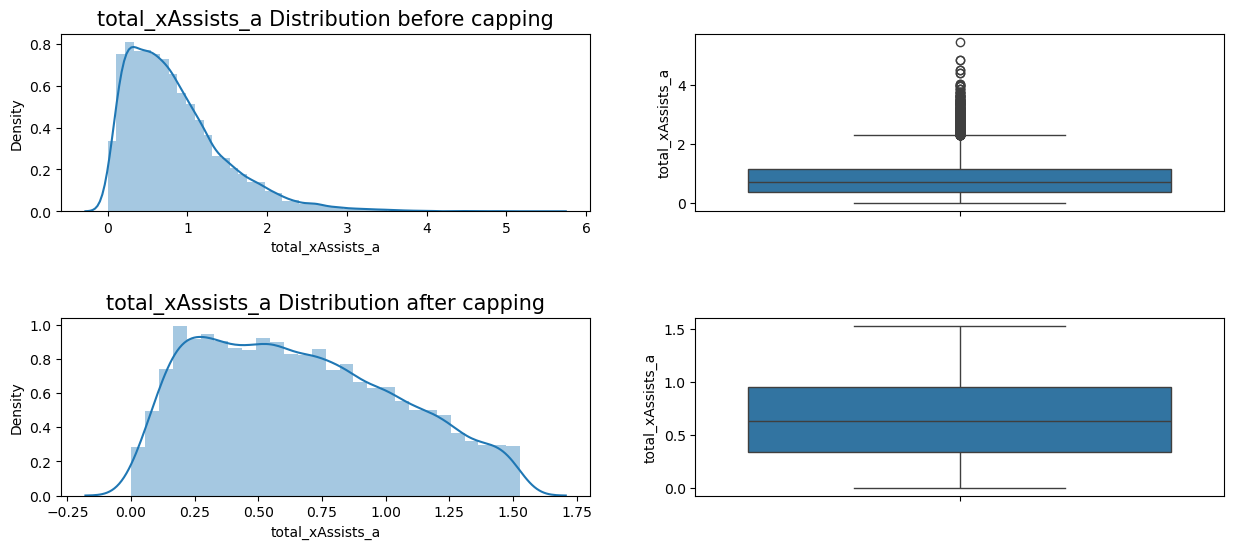

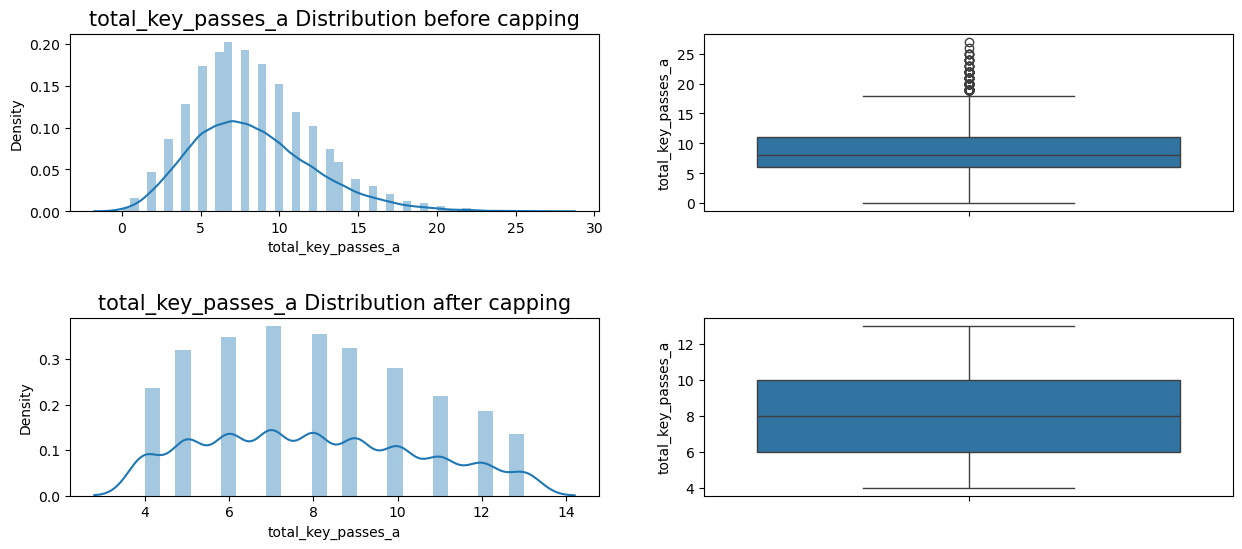

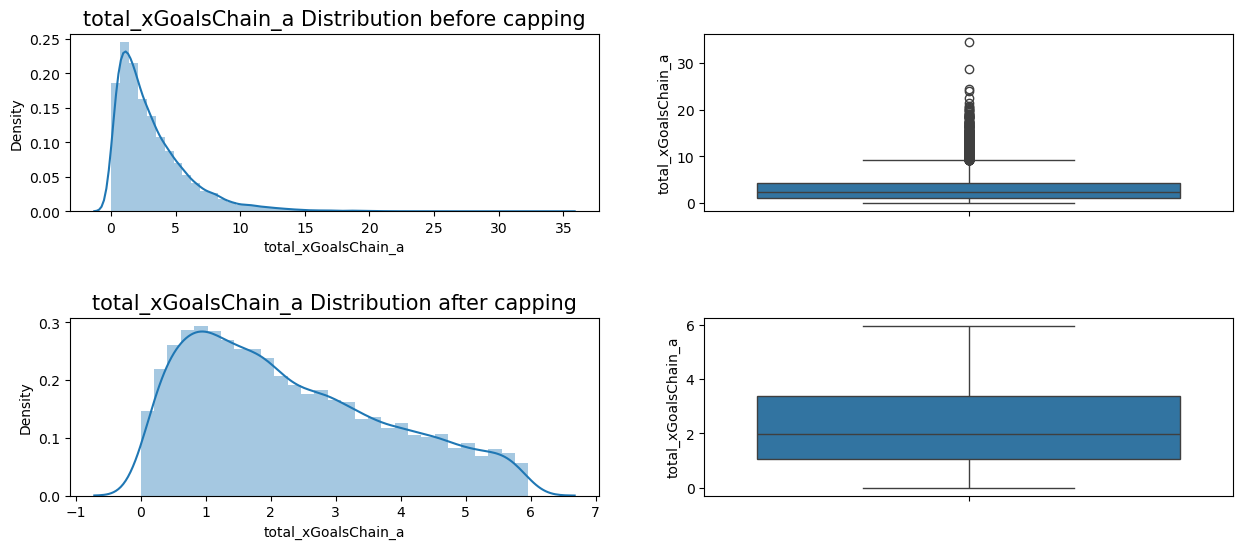

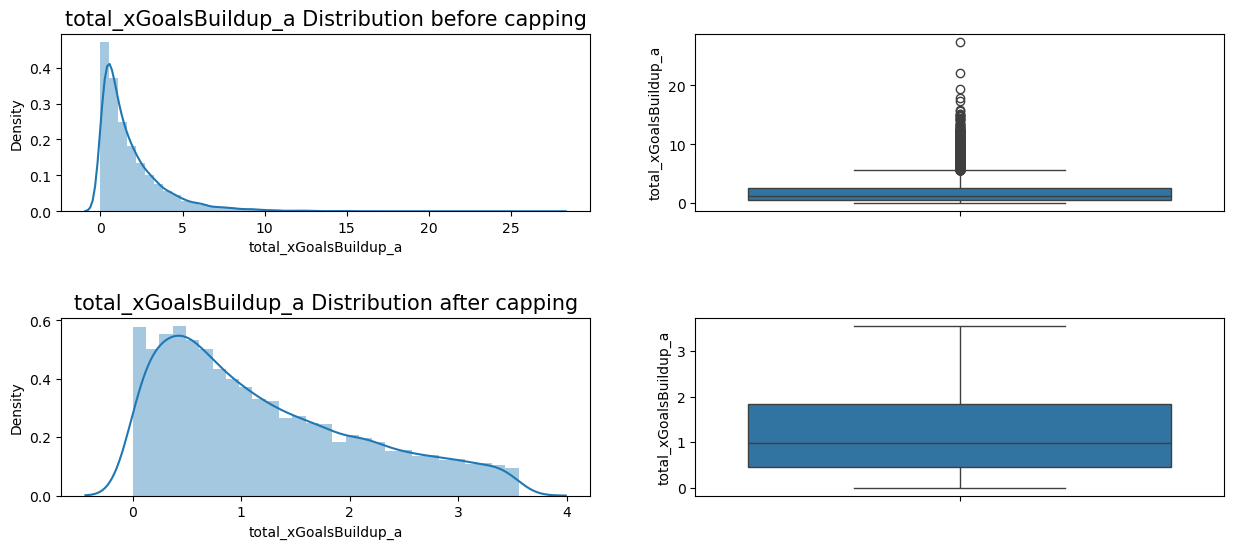

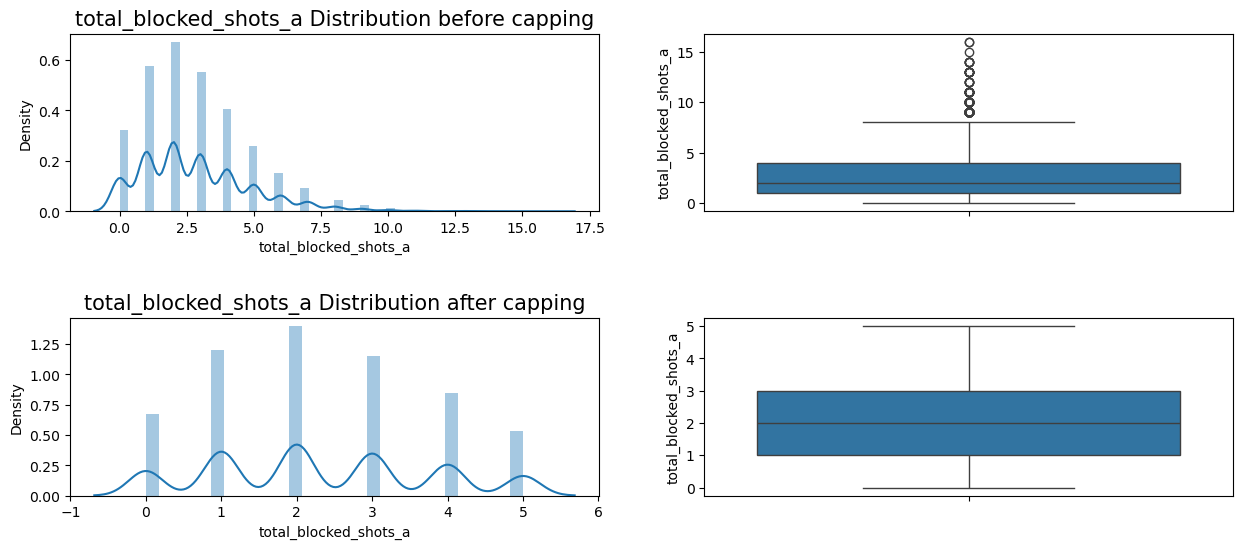

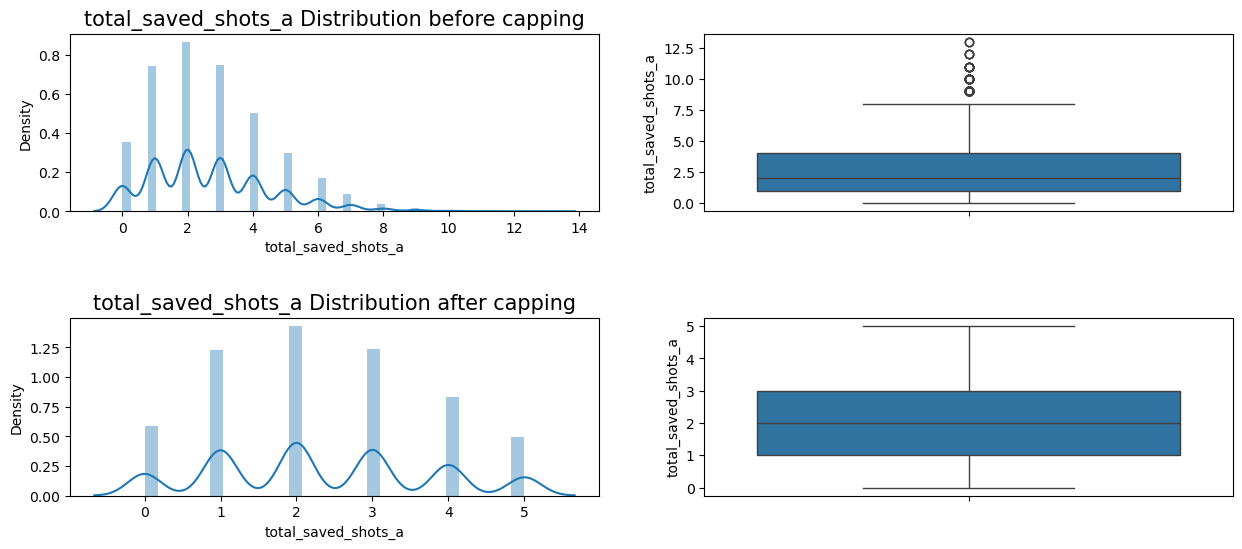

In [42]:
def dist_outliers(original_df, new, cols):
    for col in original_df:
        if col in cols:
            plt.figure(figsize=(15,6))
            plt.subplot(2,2,1)
            sns.distplot(original_df[col])
            plt.title('{} Distribution before capping'.format(col), fontsize=15)
            plt.subplot(2,2,2)
            sns.boxplot(original_df[col])
            plt.subplots_adjust(hspace = 0.6)
            plt.subplot(2,2,3)
            sns.distplot(new[col])
            plt.title('{} Distribution after capping'.format(col), fontsize=15)
            plt.subplot(2,2,4)
            sns.boxplot(new[col])
            plt.show()
dist_outliers(df_base, temp, outliers_result.index)